In [1]:
# IMPORTING LIBRARIES & DATASET
import glob
import imageio
import keras
import numpy as np
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


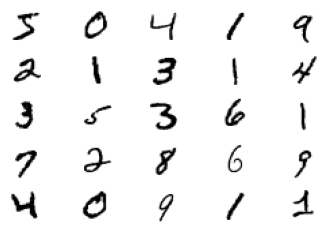

In [3]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [4]:
# MNIST dataset to train the generator and the discriminator. The generator will generate Unique handwritten
# digits resembling the MNIST data.

# Getting the images in the right dimensions
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1).astype('float32')
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1).astype('float32')
trainX = (trainX - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [15]:
batch_size = 256
half_batch = int(batch_size/2)


In [6]:
# The Generator
# The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a random noise.

# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose 
# convolution in combination with batch normalization. 


def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

   # upsample to 14x14
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    # upsample to 28x28
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


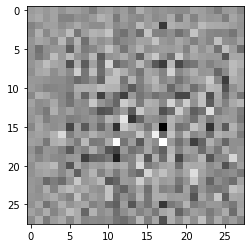

In [7]:
# Use the (as yet untrained) generator to create an image

generator = make_generator_model()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
#The Discriminator
# The discriminator is a CNN-based image classifier.

def make_discriminator_model():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    

    return model

In [9]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
# The model will be trained to output positive values for real images, and negative values for fake images.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
# define the training loop

def train(epochs, batch_size=128, save_interval=50):
    
    for epoch in range(epochs):

        #  Train Discriminator
    
        # Select a random half batch of real images
        idx = np.random.randint(0, trainX.shape[0], half_batch)
        imgs = trainX[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
      
        # take average loss from real and fake images. 
    
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)


In [11]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

In [17]:
#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.


discriminator = make_discriminator_model()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = make_generator_model()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)


z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

     
discriminator.trainable = False  


valid = discriminator(img)  #Validity check on the generated image



combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=20000, batch_size=128, save_interval=500)


generator.save('generator_model.h5')  #Test the model on GAN4_predict...


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)             

4/4 [==============================] - 0s 77ms/step
62 [D loss: 0.007512, acc.: 100.00%] [G loss: 0.000686]
4/4 [==============================] - 0s 73ms/step
63 [D loss: 0.006402, acc.: 100.00%] [G loss: 0.000655]
4/4 [==============================] - 0s 79ms/step
64 [D loss: 0.006049, acc.: 100.00%] [G loss: 0.000551]
4/4 [==============================] - 0s 76ms/step
65 [D loss: 0.006612, acc.: 100.00%] [G loss: 0.000430]
4/4 [==============================] - 0s 74ms/step
66 [D loss: 0.005471, acc.: 100.00%] [G loss: 0.000535]
4/4 [==============================] - 0s 74ms/step
67 [D loss: 0.005722, acc.: 100.00%] [G loss: 0.000465]
4/4 [==============================] - 0s 74ms/step
68 [D loss: 0.005776, acc.: 100.00%] [G loss: 0.000464]
4/4 [==============================] - 0s 75ms/step
69 [D loss: 0.005292, acc.: 100.00%] [G loss: 0.000369]
4/4 [==============================] - 0s 73ms/step
70 [D loss: 0.005908, acc.: 100.00%] [G loss: 0.000320]
4/4 [=======================

4/4 [==============================] - 0s 74ms/step
138 [D loss: 0.002508, acc.: 100.00%] [G loss: 0.000000]
4/4 [==============================] - 0s 75ms/step
139 [D loss: 0.001879, acc.: 100.00%] [G loss: 0.000000]
4/4 [==============================] - 0s 77ms/step
140 [D loss: 0.002622, acc.: 100.00%] [G loss: 0.000000]
4/4 [==============================] - 0s 79ms/step
141 [D loss: 0.002089, acc.: 100.00%] [G loss: 0.000000]
4/4 [==============================] - 0s 81ms/step
142 [D loss: 0.002821, acc.: 100.00%] [G loss: 0.000001]
4/4 [==============================] - 0s 74ms/step
143 [D loss: 0.002447, acc.: 100.00%] [G loss: 0.000004]
4/4 [==============================] - 0s 72ms/step
144 [D loss: 0.006472, acc.: 100.00%] [G loss: 0.000001]
4/4 [==============================] - 0s 75ms/step
145 [D loss: 1.788244, acc.: 49.61%] [G loss: 0.979820]
4/4 [==============================] - 0s 77ms/step
146 [D loss: 7.776979, acc.: 50.00%] [G loss: 0.892069]
4/4 [================

4/4 [==============================] - 0s 79ms/step
214 [D loss: 0.017051, acc.: 100.00%] [G loss: 0.001713]
4/4 [==============================] - 0s 76ms/step
215 [D loss: 0.015611, acc.: 100.00%] [G loss: 0.002108]
4/4 [==============================] - 0s 74ms/step
216 [D loss: 0.018231, acc.: 100.00%] [G loss: 0.002428]
4/4 [==============================] - 0s 74ms/step
217 [D loss: 0.016405, acc.: 100.00%] [G loss: 0.002057]
4/4 [==============================] - 0s 78ms/step
218 [D loss: 0.013801, acc.: 100.00%] [G loss: 0.001721]
4/4 [==============================] - 0s 77ms/step
219 [D loss: 0.018679, acc.: 100.00%] [G loss: 0.002283]
4/4 [==============================] - 0s 78ms/step
220 [D loss: 0.021587, acc.: 100.00%] [G loss: 0.001996]
4/4 [==============================] - 0s 79ms/step
221 [D loss: 0.021778, acc.: 99.61%] [G loss: 0.001998]
4/4 [==============================] - 0s 75ms/step
222 [D loss: 0.021411, acc.: 100.00%] [G loss: 0.002340]
4/4 [===============

4/4 [==============================] - 0s 78ms/step
289 [D loss: 0.008106, acc.: 100.00%] [G loss: 0.005706]
4/4 [==============================] - 0s 73ms/step
290 [D loss: 0.007095, acc.: 100.00%] [G loss: 0.006787]
4/4 [==============================] - 0s 77ms/step
291 [D loss: 0.008301, acc.: 100.00%] [G loss: 0.007078]
4/4 [==============================] - 0s 74ms/step
292 [D loss: 0.012550, acc.: 100.00%] [G loss: 0.007028]
4/4 [==============================] - 0s 77ms/step
293 [D loss: 0.010774, acc.: 100.00%] [G loss: 0.008348]
4/4 [==============================] - 0s 77ms/step
294 [D loss: 0.009153, acc.: 100.00%] [G loss: 0.007007]
4/4 [==============================] - 0s 76ms/step
295 [D loss: 0.014176, acc.: 100.00%] [G loss: 0.007470]
4/4 [==============================] - 0s 76ms/step
296 [D loss: 0.014644, acc.: 100.00%] [G loss: 0.008859]
4/4 [==============================] - 0s 78ms/step
297 [D loss: 0.013673, acc.: 100.00%] [G loss: 0.010252]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
365 [D loss: 0.369129, acc.: 88.28%] [G loss: 1.229100]
4/4 [==============================] - 0s 73ms/step
366 [D loss: 0.295886, acc.: 96.09%] [G loss: 1.521763]
4/4 [==============================] - 0s 75ms/step
367 [D loss: 0.373682, acc.: 90.23%] [G loss: 1.525721]
4/4 [==============================] - 0s 77ms/step
368 [D loss: 0.388158, acc.: 87.11%] [G loss: 1.528092]
4/4 [==============================] - 0s 75ms/step
369 [D loss: 0.530922, acc.: 73.44%] [G loss: 0.976431]
4/4 [==============================] - 0s 77ms/step
370 [D loss: 0.537406, acc.: 76.56%] [G loss: 0.312616]
4/4 [==============================] - 0s 74ms/step
371 [D loss: 0.470702, acc.: 84.77%] [G loss: 0.121864]
4/4 [==============================] - 0s 77ms/step
372 [D loss: 0.325650, acc.: 85.55%] [G loss: 0.042462]
4/4 [==============================] - 0s 77ms/step
373 [D loss: 0.290741, acc.: 92.58%] [G loss: 0.025094]
4/4 [=======================

4/4 [==============================] - 0s 79ms/step
441 [D loss: 0.120924, acc.: 97.66%] [G loss: 0.019417]
4/4 [==============================] - 0s 76ms/step
442 [D loss: 0.104705, acc.: 97.27%] [G loss: 0.025839]
4/4 [==============================] - 0s 77ms/step
443 [D loss: 0.156574, acc.: 94.92%] [G loss: 0.022276]
4/4 [==============================] - 0s 83ms/step
444 [D loss: 0.144511, acc.: 94.53%] [G loss: 0.021424]
4/4 [==============================] - 0s 84ms/step
445 [D loss: 0.127146, acc.: 96.88%] [G loss: 0.028213]
4/4 [==============================] - 0s 83ms/step
446 [D loss: 0.144590, acc.: 94.53%] [G loss: 0.022242]
4/4 [==============================] - 0s 84ms/step
447 [D loss: 0.129292, acc.: 95.70%] [G loss: 0.022535]
4/4 [==============================] - 0s 85ms/step
448 [D loss: 0.158632, acc.: 95.31%] [G loss: 0.022037]
4/4 [==============================] - 0s 83ms/step
449 [D loss: 0.145021, acc.: 94.53%] [G loss: 0.030638]
4/4 [=======================

4/4 [==============================] - 0s 78ms/step
516 [D loss: 0.884837, acc.: 32.81%] [G loss: 0.752965]
4/4 [==============================] - 0s 78ms/step
517 [D loss: 0.941197, acc.: 23.05%] [G loss: 0.735632]
4/4 [==============================] - 0s 79ms/step
518 [D loss: 0.883808, acc.: 27.34%] [G loss: 0.687923]
4/4 [==============================] - 0s 78ms/step
519 [D loss: 0.919157, acc.: 26.56%] [G loss: 0.705052]
4/4 [==============================] - 0s 77ms/step
520 [D loss: 0.863761, acc.: 32.42%] [G loss: 0.650789]
4/4 [==============================] - 0s 77ms/step
521 [D loss: 0.835919, acc.: 37.11%] [G loss: 0.656211]
4/4 [==============================] - 0s 79ms/step
522 [D loss: 0.795792, acc.: 44.53%] [G loss: 0.692540]
4/4 [==============================] - 0s 77ms/step
523 [D loss: 0.809316, acc.: 41.02%] [G loss: 0.699351]
4/4 [==============================] - 0s 79ms/step
524 [D loss: 0.808562, acc.: 35.94%] [G loss: 0.686391]
4/4 [=======================

4/4 [==============================] - 0s 79ms/step
592 [D loss: 0.790403, acc.: 35.55%] [G loss: 0.745181]
4/4 [==============================] - 0s 76ms/step
593 [D loss: 0.764354, acc.: 46.88%] [G loss: 0.715965]
4/4 [==============================] - 0s 78ms/step
594 [D loss: 0.749748, acc.: 42.97%] [G loss: 0.686812]
4/4 [==============================] - 0s 76ms/step
595 [D loss: 0.735834, acc.: 43.75%] [G loss: 0.664916]
4/4 [==============================] - 0s 78ms/step
596 [D loss: 0.768235, acc.: 39.84%] [G loss: 0.664232]
4/4 [==============================] - 0s 73ms/step
597 [D loss: 0.797864, acc.: 34.77%] [G loss: 0.631234]
4/4 [==============================] - 0s 78ms/step
598 [D loss: 0.754118, acc.: 42.19%] [G loss: 0.695812]
4/4 [==============================] - 0s 79ms/step
599 [D loss: 0.738547, acc.: 42.97%] [G loss: 0.670992]
4/4 [==============================] - 0s 78ms/step
600 [D loss: 0.749253, acc.: 42.19%] [G loss: 0.717684]
4/4 [=======================

4/4 [==============================] - 0s 78ms/step
668 [D loss: 0.762490, acc.: 35.55%] [G loss: 0.713065]
4/4 [==============================] - 0s 79ms/step
669 [D loss: 0.739054, acc.: 43.75%] [G loss: 0.726459]
4/4 [==============================] - 0s 77ms/step
670 [D loss: 0.726049, acc.: 44.14%] [G loss: 0.724022]
4/4 [==============================] - 0s 77ms/step
671 [D loss: 0.730383, acc.: 43.36%] [G loss: 0.714926]
4/4 [==============================] - 0s 72ms/step
672 [D loss: 0.758901, acc.: 41.80%] [G loss: 0.688704]
4/4 [==============================] - 0s 78ms/step
673 [D loss: 0.759160, acc.: 37.11%] [G loss: 0.680425]
4/4 [==============================] - 0s 77ms/step
674 [D loss: 0.770422, acc.: 34.77%] [G loss: 0.699650]
4/4 [==============================] - 0s 78ms/step
675 [D loss: 0.763205, acc.: 39.84%] [G loss: 0.668019]
4/4 [==============================] - 0s 74ms/step
676 [D loss: 0.753409, acc.: 34.77%] [G loss: 0.672275]
4/4 [=======================

4/4 [==============================] - 0s 77ms/step
744 [D loss: 0.722077, acc.: 48.83%] [G loss: 0.738444]
4/4 [==============================] - 0s 78ms/step
745 [D loss: 0.767584, acc.: 35.94%] [G loss: 0.736092]
4/4 [==============================] - 0s 79ms/step
746 [D loss: 0.748384, acc.: 37.11%] [G loss: 0.748899]
4/4 [==============================] - 0s 80ms/step
747 [D loss: 0.745683, acc.: 37.50%] [G loss: 0.765574]
4/4 [==============================] - 0s 78ms/step
748 [D loss: 0.708716, acc.: 48.44%] [G loss: 0.804204]
4/4 [==============================] - 0s 79ms/step
749 [D loss: 0.694580, acc.: 52.73%] [G loss: 0.810156]
4/4 [==============================] - 0s 75ms/step
750 [D loss: 0.699550, acc.: 53.91%] [G loss: 0.779377]
4/4 [==============================] - 0s 77ms/step
751 [D loss: 0.696477, acc.: 51.56%] [G loss: 0.756236]
4/4 [==============================] - 0s 78ms/step
752 [D loss: 0.751701, acc.: 42.58%] [G loss: 0.710036]
4/4 [=======================

4/4 [==============================] - 0s 75ms/step
820 [D loss: 0.719777, acc.: 42.97%] [G loss: 0.789739]
4/4 [==============================] - 0s 76ms/step
821 [D loss: 0.709800, acc.: 53.12%] [G loss: 0.785155]
4/4 [==============================] - 0s 78ms/step
822 [D loss: 0.707001, acc.: 45.70%] [G loss: 0.768422]
4/4 [==============================] - 0s 78ms/step
823 [D loss: 0.711686, acc.: 48.83%] [G loss: 0.738960]
4/4 [==============================] - 0s 75ms/step
824 [D loss: 0.733467, acc.: 45.31%] [G loss: 0.719873]
4/4 [==============================] - 0s 80ms/step
825 [D loss: 0.722980, acc.: 43.75%] [G loss: 0.739345]
4/4 [==============================] - 0s 79ms/step
826 [D loss: 0.723252, acc.: 45.70%] [G loss: 0.711855]
4/4 [==============================] - 0s 76ms/step
827 [D loss: 0.718189, acc.: 42.58%] [G loss: 0.749535]
4/4 [==============================] - 0s 78ms/step
828 [D loss: 0.720191, acc.: 44.92%] [G loss: 0.737674]
4/4 [=======================

4/4 [==============================] - 0s 78ms/step
896 [D loss: 0.705601, acc.: 50.78%] [G loss: 0.710086]
4/4 [==============================] - 0s 78ms/step
897 [D loss: 0.711334, acc.: 47.27%] [G loss: 0.736108]
4/4 [==============================] - 0s 75ms/step
898 [D loss: 0.736571, acc.: 44.14%] [G loss: 0.728232]
4/4 [==============================] - 0s 76ms/step
899 [D loss: 0.720008, acc.: 42.19%] [G loss: 0.742221]
4/4 [==============================] - 0s 78ms/step
900 [D loss: 0.747261, acc.: 34.77%] [G loss: 0.761972]
4/4 [==============================] - 0s 78ms/step
901 [D loss: 0.738899, acc.: 36.33%] [G loss: 0.772615]
4/4 [==============================] - 0s 79ms/step
902 [D loss: 0.715092, acc.: 46.48%] [G loss: 0.778358]
4/4 [==============================] - 0s 79ms/step
903 [D loss: 0.709360, acc.: 49.22%] [G loss: 0.778305]
4/4 [==============================] - 0s 78ms/step
904 [D loss: 0.716770, acc.: 45.70%] [G loss: 0.784213]
4/4 [=======================

4/4 [==============================] - 0s 78ms/step
972 [D loss: 0.698181, acc.: 53.52%] [G loss: 0.810110]
4/4 [==============================] - 0s 81ms/step
973 [D loss: 0.716010, acc.: 45.31%] [G loss: 0.758634]
4/4 [==============================] - 0s 81ms/step
974 [D loss: 0.708220, acc.: 46.48%] [G loss: 0.756254]
4/4 [==============================] - 0s 80ms/step
975 [D loss: 0.718071, acc.: 45.70%] [G loss: 0.735881]
4/4 [==============================] - 0s 76ms/step
976 [D loss: 0.727482, acc.: 39.06%] [G loss: 0.727639]
4/4 [==============================] - 0s 78ms/step
977 [D loss: 0.699423, acc.: 50.78%] [G loss: 0.713467]
4/4 [==============================] - 0s 74ms/step
978 [D loss: 0.694738, acc.: 52.73%] [G loss: 0.720743]
4/4 [==============================] - 0s 78ms/step
979 [D loss: 0.685726, acc.: 53.12%] [G loss: 0.727624]
4/4 [==============================] - 0s 79ms/step
980 [D loss: 0.660220, acc.: 64.84%] [G loss: 0.737201]
4/4 [=======================

4/4 [==============================] - 0s 78ms/step
1047 [D loss: 0.717533, acc.: 48.05%] [G loss: 0.722457]
4/4 [==============================] - 0s 77ms/step
1048 [D loss: 0.716446, acc.: 47.27%] [G loss: 0.737121]
4/4 [==============================] - 0s 78ms/step
1049 [D loss: 0.703391, acc.: 46.88%] [G loss: 0.707856]
4/4 [==============================] - 0s 77ms/step
1050 [D loss: 0.686122, acc.: 52.73%] [G loss: 0.721860]
4/4 [==============================] - 0s 78ms/step
1051 [D loss: 0.682097, acc.: 53.52%] [G loss: 0.730723]
4/4 [==============================] - 0s 74ms/step
1052 [D loss: 0.671057, acc.: 58.59%] [G loss: 0.735145]
4/4 [==============================] - 0s 77ms/step
1053 [D loss: 0.659112, acc.: 63.67%] [G loss: 0.746320]
4/4 [==============================] - 0s 76ms/step
1054 [D loss: 0.696601, acc.: 54.30%] [G loss: 0.714210]
4/4 [==============================] - 0s 78ms/step
1055 [D loss: 0.681217, acc.: 56.64%] [G loss: 0.738876]
4/4 [==============

4/4 [==============================] - 0s 82ms/step
1122 [D loss: 0.717720, acc.: 43.36%] [G loss: 0.700197]
4/4 [==============================] - 0s 78ms/step
1123 [D loss: 0.713648, acc.: 43.75%] [G loss: 0.700689]
4/4 [==============================] - 0s 82ms/step
1124 [D loss: 0.707654, acc.: 48.05%] [G loss: 0.720459]
4/4 [==============================] - 0s 84ms/step
1125 [D loss: 0.691779, acc.: 53.91%] [G loss: 0.734476]
4/4 [==============================] - 0s 86ms/step
1126 [D loss: 0.675875, acc.: 60.94%] [G loss: 0.745978]
4/4 [==============================] - 0s 90ms/step
1127 [D loss: 0.682188, acc.: 57.42%] [G loss: 0.727150]
4/4 [==============================] - 0s 82ms/step
1128 [D loss: 0.697639, acc.: 53.52%] [G loss: 0.725212]
4/4 [==============================] - 0s 81ms/step
1129 [D loss: 0.692805, acc.: 54.30%] [G loss: 0.713053]
4/4 [==============================] - 0s 80ms/step
1130 [D loss: 0.699552, acc.: 53.12%] [G loss: 0.713501]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
1197 [D loss: 0.717930, acc.: 46.09%] [G loss: 0.739658]
4/4 [==============================] - 0s 79ms/step
1198 [D loss: 0.703485, acc.: 50.00%] [G loss: 0.739369]
4/4 [==============================] - 0s 75ms/step
1199 [D loss: 0.709975, acc.: 40.62%] [G loss: 0.756913]
4/4 [==============================] - 0s 77ms/step
1200 [D loss: 0.689185, acc.: 55.47%] [G loss: 0.758333]
4/4 [==============================] - 0s 81ms/step
1201 [D loss: 0.676896, acc.: 58.98%] [G loss: 0.752674]
4/4 [==============================] - 0s 75ms/step
1202 [D loss: 0.684178, acc.: 61.72%] [G loss: 0.764262]
4/4 [==============================] - 0s 75ms/step
1203 [D loss: 0.677860, acc.: 62.11%] [G loss: 0.780881]
4/4 [==============================] - 0s 78ms/step
1204 [D loss: 0.663379, acc.: 64.06%] [G loss: 0.760222]
4/4 [==============================] - 0s 79ms/step
1205 [D loss: 0.693394, acc.: 51.17%] [G loss: 0.759808]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
1272 [D loss: 0.686561, acc.: 53.12%] [G loss: 0.761548]
4/4 [==============================] - 0s 76ms/step
1273 [D loss: 0.655661, acc.: 64.06%] [G loss: 0.779554]
4/4 [==============================] - 0s 77ms/step
1274 [D loss: 0.661589, acc.: 62.50%] [G loss: 0.775023]
4/4 [==============================] - 0s 75ms/step
1275 [D loss: 0.647075, acc.: 66.80%] [G loss: 0.782082]
4/4 [==============================] - 0s 80ms/step
1276 [D loss: 0.650592, acc.: 67.97%] [G loss: 0.773454]
4/4 [==============================] - 0s 77ms/step
1277 [D loss: 0.649548, acc.: 68.36%] [G loss: 0.766158]
4/4 [==============================] - 0s 78ms/step
1278 [D loss: 0.686029, acc.: 57.03%] [G loss: 0.751028]
4/4 [==============================] - 0s 78ms/step
1279 [D loss: 0.708506, acc.: 47.66%] [G loss: 0.733811]
4/4 [==============================] - 0s 79ms/step
1280 [D loss: 0.721960, acc.: 43.36%] [G loss: 0.740399]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
1347 [D loss: 0.731047, acc.: 39.06%] [G loss: 0.717562]
4/4 [==============================] - 0s 75ms/step
1348 [D loss: 0.727116, acc.: 45.31%] [G loss: 0.712000]
4/4 [==============================] - 0s 78ms/step
1349 [D loss: 0.710163, acc.: 46.48%] [G loss: 0.753210]
4/4 [==============================] - 0s 79ms/step
1350 [D loss: 0.709388, acc.: 47.66%] [G loss: 0.765092]
4/4 [==============================] - 0s 77ms/step
1351 [D loss: 0.688576, acc.: 56.64%] [G loss: 0.782215]
4/4 [==============================] - 0s 77ms/step
1352 [D loss: 0.681951, acc.: 57.03%] [G loss: 0.805366]
4/4 [==============================] - 0s 78ms/step
1353 [D loss: 0.678602, acc.: 57.81%] [G loss: 0.782298]
4/4 [==============================] - 0s 76ms/step
1354 [D loss: 0.696504, acc.: 52.73%] [G loss: 0.801034]
4/4 [==============================] - 0s 80ms/step
1355 [D loss: 0.705664, acc.: 50.00%] [G loss: 0.805113]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
1422 [D loss: 0.646024, acc.: 67.97%] [G loss: 0.797368]
4/4 [==============================] - 0s 79ms/step
1423 [D loss: 0.641853, acc.: 72.27%] [G loss: 0.783811]
4/4 [==============================] - 0s 80ms/step
1424 [D loss: 0.671047, acc.: 60.55%] [G loss: 0.766835]
4/4 [==============================] - 0s 79ms/step
1425 [D loss: 0.643239, acc.: 64.45%] [G loss: 0.744644]
4/4 [==============================] - 0s 77ms/step
1426 [D loss: 0.688696, acc.: 50.78%] [G loss: 0.735331]
4/4 [==============================] - 0s 77ms/step
1427 [D loss: 0.690232, acc.: 52.73%] [G loss: 0.731764]
4/4 [==============================] - 0s 77ms/step
1428 [D loss: 0.713121, acc.: 46.48%] [G loss: 0.719273]
4/4 [==============================] - 0s 78ms/step
1429 [D loss: 0.743429, acc.: 36.72%] [G loss: 0.698996]
4/4 [==============================] - 0s 77ms/step
1430 [D loss: 0.735923, acc.: 43.36%] [G loss: 0.705171]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
1497 [D loss: 0.674676, acc.: 59.77%] [G loss: 0.788283]
4/4 [==============================] - 0s 78ms/step
1498 [D loss: 0.688723, acc.: 54.69%] [G loss: 0.783413]
4/4 [==============================] - 0s 78ms/step
1499 [D loss: 0.666838, acc.: 60.94%] [G loss: 0.765563]
4/4 [==============================] - 0s 78ms/step
1500 [D loss: 0.667191, acc.: 62.89%] [G loss: 0.752279]
4/4 [==============================] - 0s 79ms/step
1501 [D loss: 0.674515, acc.: 60.16%] [G loss: 0.767766]
4/4 [==============================] - 0s 76ms/step
1502 [D loss: 0.681983, acc.: 58.20%] [G loss: 0.774377]
4/4 [==============================] - 0s 78ms/step
1503 [D loss: 0.667412, acc.: 62.50%] [G loss: 0.771960]
4/4 [==============================] - 0s 78ms/step
1504 [D loss: 0.665950, acc.: 58.59%] [G loss: 0.795645]
4/4 [==============================] - 0s 79ms/step
1505 [D loss: 0.639559, acc.: 72.27%] [G loss: 0.794495]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
1572 [D loss: 0.723107, acc.: 43.75%] [G loss: 0.745162]
4/4 [==============================] - 0s 73ms/step
1573 [D loss: 0.715241, acc.: 45.70%] [G loss: 0.722977]
4/4 [==============================] - 0s 73ms/step
1574 [D loss: 0.700778, acc.: 47.66%] [G loss: 0.755495]
4/4 [==============================] - 0s 76ms/step
1575 [D loss: 0.711409, acc.: 51.56%] [G loss: 0.767069]
4/4 [==============================] - 0s 77ms/step
1576 [D loss: 0.705747, acc.: 49.61%] [G loss: 0.787748]
4/4 [==============================] - 0s 78ms/step
1577 [D loss: 0.685766, acc.: 53.12%] [G loss: 0.798242]
4/4 [==============================] - 0s 78ms/step
1578 [D loss: 0.687030, acc.: 55.08%] [G loss: 0.794301]
4/4 [==============================] - 0s 78ms/step
1579 [D loss: 0.688248, acc.: 51.17%] [G loss: 0.769351]
4/4 [==============================] - 0s 77ms/step
1580 [D loss: 0.701030, acc.: 54.30%] [G loss: 0.763229]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
1647 [D loss: 0.690187, acc.: 58.59%] [G loss: 0.822014]
4/4 [==============================] - 0s 78ms/step
1648 [D loss: 0.655624, acc.: 69.14%] [G loss: 0.825636]
4/4 [==============================] - 0s 74ms/step
1649 [D loss: 0.656538, acc.: 66.80%] [G loss: 0.842779]
4/4 [==============================] - 0s 78ms/step
1650 [D loss: 0.661368, acc.: 63.28%] [G loss: 0.840890]
4/4 [==============================] - 0s 78ms/step
1651 [D loss: 0.655123, acc.: 64.84%] [G loss: 0.837531]
4/4 [==============================] - 0s 77ms/step
1652 [D loss: 0.686921, acc.: 56.64%] [G loss: 0.771791]
4/4 [==============================] - 0s 77ms/step
1653 [D loss: 0.658879, acc.: 65.62%] [G loss: 0.785097]
4/4 [==============================] - 0s 75ms/step
1654 [D loss: 0.700611, acc.: 51.17%] [G loss: 0.755266]
4/4 [==============================] - 0s 78ms/step
1655 [D loss: 0.723766, acc.: 45.31%] [G loss: 0.730726]
4/4 [==============

4/4 [==============================] - 0s 71ms/step
1722 [D loss: 0.683367, acc.: 55.08%] [G loss: 0.785415]
4/4 [==============================] - 0s 80ms/step
1723 [D loss: 0.668573, acc.: 62.11%] [G loss: 0.745915]
4/4 [==============================] - 0s 79ms/step
1724 [D loss: 0.693551, acc.: 50.78%] [G loss: 0.742788]
4/4 [==============================] - 0s 78ms/step
1725 [D loss: 0.692763, acc.: 53.12%] [G loss: 0.731272]
4/4 [==============================] - 0s 78ms/step
1726 [D loss: 0.700602, acc.: 49.61%] [G loss: 0.718793]
4/4 [==============================] - 0s 76ms/step
1727 [D loss: 0.697348, acc.: 51.56%] [G loss: 0.730347]
4/4 [==============================] - 0s 78ms/step
1728 [D loss: 0.693628, acc.: 51.95%] [G loss: 0.760551]
4/4 [==============================] - 0s 78ms/step
1729 [D loss: 0.690832, acc.: 53.91%] [G loss: 0.735116]
4/4 [==============================] - 0s 78ms/step
1730 [D loss: 0.678677, acc.: 57.81%] [G loss: 0.755245]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
1797 [D loss: 0.712790, acc.: 47.66%] [G loss: 0.726222]
4/4 [==============================] - 0s 74ms/step
1798 [D loss: 0.688243, acc.: 57.03%] [G loss: 0.768936]
4/4 [==============================] - 0s 75ms/step
1799 [D loss: 0.664126, acc.: 60.16%] [G loss: 0.808286]
4/4 [==============================] - 0s 76ms/step
1800 [D loss: 0.636627, acc.: 69.92%] [G loss: 0.856112]
4/4 [==============================] - 0s 75ms/step
1801 [D loss: 0.635936, acc.: 74.22%] [G loss: 0.845510]
4/4 [==============================] - 0s 77ms/step
1802 [D loss: 0.624755, acc.: 73.83%] [G loss: 0.848586]
4/4 [==============================] - 0s 81ms/step
1803 [D loss: 0.636585, acc.: 73.05%] [G loss: 0.832996]
4/4 [==============================] - 0s 83ms/step
1804 [D loss: 0.668376, acc.: 62.11%] [G loss: 0.778770]
4/4 [==============================] - 0s 76ms/step
1805 [D loss: 0.697446, acc.: 54.30%] [G loss: 0.754037]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
1872 [D loss: 0.680801, acc.: 58.98%] [G loss: 0.753453]
4/4 [==============================] - 0s 78ms/step
1873 [D loss: 0.669170, acc.: 60.94%] [G loss: 0.789842]
4/4 [==============================] - 0s 78ms/step
1874 [D loss: 0.664497, acc.: 62.50%] [G loss: 0.763981]
4/4 [==============================] - 0s 78ms/step
1875 [D loss: 0.686420, acc.: 55.86%] [G loss: 0.732138]
4/4 [==============================] - 0s 78ms/step
1876 [D loss: 0.702483, acc.: 52.34%] [G loss: 0.737260]
4/4 [==============================] - 0s 77ms/step
1877 [D loss: 0.722675, acc.: 42.19%] [G loss: 0.743084]
4/4 [==============================] - 0s 78ms/step
1878 [D loss: 0.719420, acc.: 41.41%] [G loss: 0.717048]
4/4 [==============================] - 0s 77ms/step
1879 [D loss: 0.708530, acc.: 47.27%] [G loss: 0.736618]
4/4 [==============================] - 0s 77ms/step
1880 [D loss: 0.711124, acc.: 49.22%] [G loss: 0.758915]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
1947 [D loss: 0.688077, acc.: 55.08%] [G loss: 0.774585]
4/4 [==============================] - 0s 76ms/step
1948 [D loss: 0.697308, acc.: 50.00%] [G loss: 0.758162]
4/4 [==============================] - 0s 78ms/step
1949 [D loss: 0.690474, acc.: 53.12%] [G loss: 0.752777]
4/4 [==============================] - 0s 75ms/step
1950 [D loss: 0.682966, acc.: 53.52%] [G loss: 0.754838]
4/4 [==============================] - 0s 79ms/step
1951 [D loss: 0.683848, acc.: 57.81%] [G loss: 0.765403]
4/4 [==============================] - 0s 75ms/step
1952 [D loss: 0.684760, acc.: 55.47%] [G loss: 0.766410]
4/4 [==============================] - 0s 74ms/step
1953 [D loss: 0.679187, acc.: 56.25%] [G loss: 0.736574]
4/4 [==============================] - 0s 76ms/step
1954 [D loss: 0.690744, acc.: 54.69%] [G loss: 0.746149]
4/4 [==============================] - 0s 74ms/step
1955 [D loss: 0.685672, acc.: 57.42%] [G loss: 0.743835]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2022 [D loss: 0.673523, acc.: 62.50%] [G loss: 0.750197]
4/4 [==============================] - 0s 80ms/step
2023 [D loss: 0.714059, acc.: 46.48%] [G loss: 0.746258]
4/4 [==============================] - 0s 75ms/step
2024 [D loss: 0.726492, acc.: 43.36%] [G loss: 0.701632]
4/4 [==============================] - 0s 77ms/step
2025 [D loss: 0.733918, acc.: 40.23%] [G loss: 0.705000]
4/4 [==============================] - 0s 78ms/step
2026 [D loss: 0.725275, acc.: 43.75%] [G loss: 0.699434]
4/4 [==============================] - 0s 75ms/step
2027 [D loss: 0.717553, acc.: 47.27%] [G loss: 0.712642]
4/4 [==============================] - 0s 78ms/step
2028 [D loss: 0.699226, acc.: 51.17%] [G loss: 0.730898]
4/4 [==============================] - 0s 78ms/step
2029 [D loss: 0.684992, acc.: 53.91%] [G loss: 0.746177]
4/4 [==============================] - 0s 78ms/step
2030 [D loss: 0.667413, acc.: 63.28%] [G loss: 0.772804]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2097 [D loss: 0.687144, acc.: 56.25%] [G loss: 0.749918]
4/4 [==============================] - 0s 77ms/step
2098 [D loss: 0.672755, acc.: 59.38%] [G loss: 0.750783]
4/4 [==============================] - 0s 76ms/step
2099 [D loss: 0.688818, acc.: 57.81%] [G loss: 0.753875]
4/4 [==============================] - 0s 78ms/step
2100 [D loss: 0.676730, acc.: 56.64%] [G loss: 0.758498]
4/4 [==============================] - 0s 78ms/step
2101 [D loss: 0.696062, acc.: 52.73%] [G loss: 0.756870]
4/4 [==============================] - 0s 78ms/step
2102 [D loss: 0.689357, acc.: 54.30%] [G loss: 0.758354]
4/4 [==============================] - 0s 79ms/step
2103 [D loss: 0.696918, acc.: 51.17%] [G loss: 0.738977]
4/4 [==============================] - 0s 78ms/step
2104 [D loss: 0.692473, acc.: 50.78%] [G loss: 0.755248]
4/4 [==============================] - 0s 79ms/step
2105 [D loss: 0.692969, acc.: 52.34%] [G loss: 0.758853]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
2172 [D loss: 0.667497, acc.: 63.67%] [G loss: 0.755595]
4/4 [==============================] - 0s 78ms/step
2173 [D loss: 0.687907, acc.: 55.86%] [G loss: 0.763982]
4/4 [==============================] - 0s 77ms/step
2174 [D loss: 0.687763, acc.: 54.30%] [G loss: 0.733570]
4/4 [==============================] - 0s 78ms/step
2175 [D loss: 0.706256, acc.: 48.83%] [G loss: 0.741233]
4/4 [==============================] - 0s 75ms/step
2176 [D loss: 0.720415, acc.: 42.97%] [G loss: 0.715969]
4/4 [==============================] - 0s 78ms/step
2177 [D loss: 0.714578, acc.: 44.53%] [G loss: 0.707989]
4/4 [==============================] - 0s 75ms/step
2178 [D loss: 0.721783, acc.: 38.28%] [G loss: 0.702899]
4/4 [==============================] - 0s 77ms/step
2179 [D loss: 0.728910, acc.: 40.23%] [G loss: 0.723060]
4/4 [==============================] - 0s 75ms/step
2180 [D loss: 0.683154, acc.: 52.73%] [G loss: 0.748693]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2247 [D loss: 0.702538, acc.: 49.61%] [G loss: 0.742898]
4/4 [==============================] - 0s 79ms/step
2248 [D loss: 0.701352, acc.: 51.56%] [G loss: 0.741999]
4/4 [==============================] - 0s 77ms/step
2249 [D loss: 0.704247, acc.: 47.66%] [G loss: 0.735235]
4/4 [==============================] - 0s 74ms/step
2250 [D loss: 0.693230, acc.: 51.17%] [G loss: 0.754228]
4/4 [==============================] - 0s 78ms/step
2251 [D loss: 0.688605, acc.: 57.03%] [G loss: 0.778181]
4/4 [==============================] - 0s 75ms/step
2252 [D loss: 0.684293, acc.: 54.69%] [G loss: 0.772958]
4/4 [==============================] - 0s 79ms/step
2253 [D loss: 0.678755, acc.: 56.25%] [G loss: 0.791978]
4/4 [==============================] - 0s 76ms/step
2254 [D loss: 0.677314, acc.: 58.98%] [G loss: 0.784341]
4/4 [==============================] - 0s 79ms/step
2255 [D loss: 0.676363, acc.: 58.59%] [G loss: 0.759868]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
2322 [D loss: 0.685039, acc.: 52.73%] [G loss: 0.754556]
4/4 [==============================] - 0s 79ms/step
2323 [D loss: 0.684429, acc.: 55.08%] [G loss: 0.739709]
4/4 [==============================] - 0s 77ms/step
2324 [D loss: 0.704153, acc.: 50.39%] [G loss: 0.744806]
4/4 [==============================] - 0s 77ms/step
2325 [D loss: 0.691018, acc.: 53.12%] [G loss: 0.746393]
4/4 [==============================] - 0s 72ms/step
2326 [D loss: 0.693254, acc.: 50.39%] [G loss: 0.764525]
4/4 [==============================] - 0s 77ms/step
2327 [D loss: 0.685701, acc.: 56.25%] [G loss: 0.749962]
4/4 [==============================] - 0s 78ms/step
2328 [D loss: 0.671586, acc.: 57.81%] [G loss: 0.765251]
4/4 [==============================] - 0s 78ms/step
2329 [D loss: 0.679172, acc.: 58.20%] [G loss: 0.740332]
4/4 [==============================] - 0s 77ms/step
2330 [D loss: 0.683599, acc.: 56.64%] [G loss: 0.750187]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2397 [D loss: 0.710075, acc.: 46.88%] [G loss: 0.736108]
4/4 [==============================] - 0s 78ms/step
2398 [D loss: 0.681995, acc.: 61.33%] [G loss: 0.795692]
4/4 [==============================] - 0s 79ms/step
2399 [D loss: 0.658268, acc.: 66.02%] [G loss: 0.837766]
4/4 [==============================] - 0s 77ms/step
2400 [D loss: 0.647999, acc.: 69.92%] [G loss: 0.856114]
4/4 [==============================] - 0s 78ms/step
2401 [D loss: 0.671075, acc.: 62.50%] [G loss: 0.820363]
4/4 [==============================] - 0s 78ms/step
2402 [D loss: 0.661963, acc.: 60.94%] [G loss: 0.810742]
4/4 [==============================] - 0s 74ms/step
2403 [D loss: 0.703458, acc.: 51.56%] [G loss: 0.793684]
4/4 [==============================] - 0s 77ms/step
2404 [D loss: 0.717269, acc.: 47.27%] [G loss: 0.719892]
4/4 [==============================] - 0s 75ms/step
2405 [D loss: 0.736827, acc.: 36.72%] [G loss: 0.692004]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2472 [D loss: 0.697810, acc.: 55.08%] [G loss: 0.752055]
4/4 [==============================] - 0s 77ms/step
2473 [D loss: 0.715354, acc.: 44.92%] [G loss: 0.723410]
4/4 [==============================] - 0s 73ms/step
2474 [D loss: 0.716481, acc.: 47.27%] [G loss: 0.718961]
4/4 [==============================] - 0s 78ms/step
2475 [D loss: 0.709264, acc.: 48.05%] [G loss: 0.712172]
4/4 [==============================] - 0s 79ms/step
2476 [D loss: 0.702044, acc.: 50.00%] [G loss: 0.730159]
4/4 [==============================] - 0s 77ms/step
2477 [D loss: 0.702470, acc.: 46.88%] [G loss: 0.743478]
4/4 [==============================] - 0s 80ms/step
2478 [D loss: 0.691188, acc.: 51.95%] [G loss: 0.770373]
4/4 [==============================] - 0s 78ms/step
2479 [D loss: 0.681382, acc.: 55.86%] [G loss: 0.782963]
4/4 [==============================] - 0s 77ms/step
2480 [D loss: 0.683663, acc.: 56.64%] [G loss: 0.806369]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
2547 [D loss: 0.677972, acc.: 57.03%] [G loss: 0.763474]
4/4 [==============================] - 0s 79ms/step
2548 [D loss: 0.681045, acc.: 55.08%] [G loss: 0.748643]
4/4 [==============================] - 0s 80ms/step
2549 [D loss: 0.677340, acc.: 56.25%] [G loss: 0.745785]
4/4 [==============================] - 0s 77ms/step
2550 [D loss: 0.677566, acc.: 56.64%] [G loss: 0.721571]
4/4 [==============================] - 0s 78ms/step
2551 [D loss: 0.697302, acc.: 53.52%] [G loss: 0.715434]
4/4 [==============================] - 0s 76ms/step
2552 [D loss: 0.713607, acc.: 45.31%] [G loss: 0.708068]
4/4 [==============================] - 0s 75ms/step
2553 [D loss: 0.710263, acc.: 44.92%] [G loss: 0.702888]
4/4 [==============================] - 0s 78ms/step
2554 [D loss: 0.711092, acc.: 44.92%] [G loss: 0.719370]
4/4 [==============================] - 0s 77ms/step
2555 [D loss: 0.708896, acc.: 44.92%] [G loss: 0.743773]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
2622 [D loss: 0.663774, acc.: 62.11%] [G loss: 0.752215]
4/4 [==============================] - 0s 78ms/step
2623 [D loss: 0.685758, acc.: 56.64%] [G loss: 0.756859]
4/4 [==============================] - 0s 76ms/step
2624 [D loss: 0.694993, acc.: 53.12%] [G loss: 0.727813]
4/4 [==============================] - 0s 77ms/step
2625 [D loss: 0.697068, acc.: 51.56%] [G loss: 0.709426]
4/4 [==============================] - 0s 78ms/step
2626 [D loss: 0.712502, acc.: 44.14%] [G loss: 0.734593]
4/4 [==============================] - 0s 79ms/step
2627 [D loss: 0.722304, acc.: 41.02%] [G loss: 0.728012]
4/4 [==============================] - 0s 74ms/step
2628 [D loss: 0.698039, acc.: 46.88%] [G loss: 0.700738]
4/4 [==============================] - 0s 77ms/step
2629 [D loss: 0.692686, acc.: 51.95%] [G loss: 0.721262]
4/4 [==============================] - 0s 77ms/step
2630 [D loss: 0.701089, acc.: 45.70%] [G loss: 0.740275]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2697 [D loss: 0.699020, acc.: 52.34%] [G loss: 0.692082]
4/4 [==============================] - 0s 77ms/step
2698 [D loss: 0.709959, acc.: 44.92%] [G loss: 0.724434]
4/4 [==============================] - 0s 74ms/step
2699 [D loss: 0.694627, acc.: 50.78%] [G loss: 0.724517]
4/4 [==============================] - 0s 78ms/step
2700 [D loss: 0.693845, acc.: 53.12%] [G loss: 0.735030]
4/4 [==============================] - 0s 77ms/step
2701 [D loss: 0.687121, acc.: 55.47%] [G loss: 0.751645]
4/4 [==============================] - 0s 77ms/step
2702 [D loss: 0.685031, acc.: 54.69%] [G loss: 0.744750]
4/4 [==============================] - 0s 81ms/step
2703 [D loss: 0.677232, acc.: 58.59%] [G loss: 0.754680]
4/4 [==============================] - 0s 76ms/step
2704 [D loss: 0.679457, acc.: 58.59%] [G loss: 0.738219]
4/4 [==============================] - 0s 81ms/step
2705 [D loss: 0.686808, acc.: 53.91%] [G loss: 0.752215]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2772 [D loss: 0.681202, acc.: 58.98%] [G loss: 0.752698]
4/4 [==============================] - 0s 77ms/step
2773 [D loss: 0.685229, acc.: 57.42%] [G loss: 0.756470]
4/4 [==============================] - 0s 75ms/step
2774 [D loss: 0.671145, acc.: 56.25%] [G loss: 0.754657]
4/4 [==============================] - 0s 78ms/step
2775 [D loss: 0.678732, acc.: 57.03%] [G loss: 0.752363]
4/4 [==============================] - 0s 79ms/step
2776 [D loss: 0.692674, acc.: 53.12%] [G loss: 0.753302]
4/4 [==============================] - 0s 78ms/step
2777 [D loss: 0.686575, acc.: 52.73%] [G loss: 0.719135]
4/4 [==============================] - 0s 78ms/step
2778 [D loss: 0.702283, acc.: 50.39%] [G loss: 0.719779]
4/4 [==============================] - 0s 75ms/step
2779 [D loss: 0.704280, acc.: 49.61%] [G loss: 0.705666]
4/4 [==============================] - 0s 78ms/step
2780 [D loss: 0.706435, acc.: 45.31%] [G loss: 0.704157]
4/4 [==============

4/4 [==============================] - 0s 74ms/step
2847 [D loss: 0.703682, acc.: 49.61%] [G loss: 0.710459]
4/4 [==============================] - 0s 78ms/step
2848 [D loss: 0.718571, acc.: 40.62%] [G loss: 0.711928]
4/4 [==============================] - 0s 79ms/step
2849 [D loss: 0.703908, acc.: 49.22%] [G loss: 0.721440]
4/4 [==============================] - 0s 74ms/step
2850 [D loss: 0.691262, acc.: 53.52%] [G loss: 0.743600]
4/4 [==============================] - 0s 77ms/step
2851 [D loss: 0.682123, acc.: 56.64%] [G loss: 0.751540]
4/4 [==============================] - 0s 78ms/step
2852 [D loss: 0.681891, acc.: 55.08%] [G loss: 0.765427]
4/4 [==============================] - 0s 77ms/step
2853 [D loss: 0.682057, acc.: 56.25%] [G loss: 0.765867]
4/4 [==============================] - 0s 74ms/step
2854 [D loss: 0.682913, acc.: 58.98%] [G loss: 0.788547]
4/4 [==============================] - 0s 79ms/step
2855 [D loss: 0.686173, acc.: 57.03%] [G loss: 0.777762]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2922 [D loss: 0.664455, acc.: 65.62%] [G loss: 0.786095]
4/4 [==============================] - 0s 77ms/step
2923 [D loss: 0.643770, acc.: 71.09%] [G loss: 0.785152]
4/4 [==============================] - 0s 75ms/step
2924 [D loss: 0.644870, acc.: 70.31%] [G loss: 0.796417]
4/4 [==============================] - 0s 78ms/step
2925 [D loss: 0.678708, acc.: 57.42%] [G loss: 0.793338]
4/4 [==============================] - 0s 77ms/step
2926 [D loss: 0.670805, acc.: 61.72%] [G loss: 0.743307]
4/4 [==============================] - 0s 78ms/step
2927 [D loss: 0.701187, acc.: 51.95%] [G loss: 0.706151]
4/4 [==============================] - 0s 79ms/step
2928 [D loss: 0.718454, acc.: 46.88%] [G loss: 0.680562]
4/4 [==============================] - 0s 74ms/step
2929 [D loss: 0.708015, acc.: 48.05%] [G loss: 0.677881]
4/4 [==============================] - 0s 75ms/step
2930 [D loss: 0.718904, acc.: 45.31%] [G loss: 0.686186]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
2997 [D loss: 0.717350, acc.: 42.58%] [G loss: 0.713856]
4/4 [==============================] - 0s 79ms/step
2998 [D loss: 0.714816, acc.: 42.58%] [G loss: 0.740758]
4/4 [==============================] - 0s 77ms/step
2999 [D loss: 0.703061, acc.: 47.27%] [G loss: 0.747187]
4/4 [==============================] - 0s 74ms/step
3000 [D loss: 0.694146, acc.: 53.52%] [G loss: 0.756494]
4/4 [==============================] - 0s 79ms/step
3001 [D loss: 0.687738, acc.: 55.08%] [G loss: 0.767150]
4/4 [==============================] - 0s 78ms/step
3002 [D loss: 0.682534, acc.: 54.69%] [G loss: 0.759739]
4/4 [==============================] - 0s 79ms/step
3003 [D loss: 0.693535, acc.: 50.78%] [G loss: 0.766666]
4/4 [==============================] - 0s 77ms/step
3004 [D loss: 0.675798, acc.: 57.81%] [G loss: 0.770178]
4/4 [==============================] - 0s 77ms/step
3005 [D loss: 0.698955, acc.: 53.52%] [G loss: 0.767706]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
3072 [D loss: 0.698730, acc.: 51.17%] [G loss: 0.726617]
4/4 [==============================] - 0s 79ms/step
3073 [D loss: 0.697175, acc.: 50.00%] [G loss: 0.762377]
4/4 [==============================] - 0s 76ms/step
3074 [D loss: 0.678563, acc.: 58.59%] [G loss: 0.765723]
4/4 [==============================] - 0s 75ms/step
3075 [D loss: 0.656767, acc.: 63.28%] [G loss: 0.791283]
4/4 [==============================] - 0s 77ms/step
3076 [D loss: 0.661100, acc.: 62.11%] [G loss: 0.787380]
4/4 [==============================] - 0s 75ms/step
3077 [D loss: 0.667947, acc.: 62.89%] [G loss: 0.781659]
4/4 [==============================] - 0s 76ms/step
3078 [D loss: 0.702550, acc.: 48.44%] [G loss: 0.745595]
4/4 [==============================] - 0s 79ms/step
3079 [D loss: 0.701949, acc.: 49.61%] [G loss: 0.732029]
4/4 [==============================] - 0s 78ms/step
3080 [D loss: 0.726140, acc.: 40.23%] [G loss: 0.706146]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
3147 [D loss: 0.704491, acc.: 49.61%] [G loss: 0.739595]
4/4 [==============================] - 0s 77ms/step
3148 [D loss: 0.699616, acc.: 50.39%] [G loss: 0.726023]
4/4 [==============================] - 0s 80ms/step
3149 [D loss: 0.696416, acc.: 50.39%] [G loss: 0.739411]
4/4 [==============================] - 0s 77ms/step
3150 [D loss: 0.703456, acc.: 49.22%] [G loss: 0.741445]
4/4 [==============================] - 0s 78ms/step
3151 [D loss: 0.675610, acc.: 61.33%] [G loss: 0.771103]
4/4 [==============================] - 0s 75ms/step
3152 [D loss: 0.661990, acc.: 66.02%] [G loss: 0.772520]
4/4 [==============================] - 0s 79ms/step
3153 [D loss: 0.670015, acc.: 60.16%] [G loss: 0.791434]
4/4 [==============================] - 0s 74ms/step
3154 [D loss: 0.661389, acc.: 61.33%] [G loss: 0.783938]
4/4 [==============================] - 0s 80ms/step
3155 [D loss: 0.674893, acc.: 60.16%] [G loss: 0.764505]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
3222 [D loss: 0.678383, acc.: 56.64%] [G loss: 0.748388]
4/4 [==============================] - 0s 74ms/step
3223 [D loss: 0.683430, acc.: 59.38%] [G loss: 0.737121]
4/4 [==============================] - 0s 77ms/step
3224 [D loss: 0.693218, acc.: 52.73%] [G loss: 0.727997]
4/4 [==============================] - 0s 77ms/step
3225 [D loss: 0.682883, acc.: 57.81%] [G loss: 0.744785]
4/4 [==============================] - 0s 76ms/step
3226 [D loss: 0.690243, acc.: 53.12%] [G loss: 0.737927]
4/4 [==============================] - 0s 78ms/step
3227 [D loss: 0.684513, acc.: 55.08%] [G loss: 0.742378]
4/4 [==============================] - 0s 79ms/step
3228 [D loss: 0.692514, acc.: 56.64%] [G loss: 0.770069]
4/4 [==============================] - 0s 77ms/step
3229 [D loss: 0.673486, acc.: 59.38%] [G loss: 0.761951]
4/4 [==============================] - 0s 75ms/step
3230 [D loss: 0.666774, acc.: 62.50%] [G loss: 0.771118]
4/4 [==============

4/4 [==============================] - 0s 74ms/step
3297 [D loss: 0.677209, acc.: 60.55%] [G loss: 0.751199]
4/4 [==============================] - 0s 78ms/step
3298 [D loss: 0.672942, acc.: 59.38%] [G loss: 0.742895]
4/4 [==============================] - 0s 77ms/step
3299 [D loss: 0.677470, acc.: 55.08%] [G loss: 0.755067]
4/4 [==============================] - 0s 78ms/step
3300 [D loss: 0.684727, acc.: 55.08%] [G loss: 0.755770]
4/4 [==============================] - 0s 77ms/step
3301 [D loss: 0.695640, acc.: 48.05%] [G loss: 0.762883]
4/4 [==============================] - 0s 78ms/step
3302 [D loss: 0.685356, acc.: 56.25%] [G loss: 0.739787]
4/4 [==============================] - 0s 77ms/step
3303 [D loss: 0.687861, acc.: 53.12%] [G loss: 0.738828]
4/4 [==============================] - 0s 77ms/step
3304 [D loss: 0.698701, acc.: 50.39%] [G loss: 0.749262]
4/4 [==============================] - 0s 77ms/step
3305 [D loss: 0.692253, acc.: 52.34%] [G loss: 0.733271]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
3372 [D loss: 0.693866, acc.: 54.69%] [G loss: 0.753176]
4/4 [==============================] - 0s 75ms/step
3373 [D loss: 0.689990, acc.: 53.52%] [G loss: 0.738345]
4/4 [==============================] - 0s 76ms/step
3374 [D loss: 0.683283, acc.: 55.47%] [G loss: 0.721845]
4/4 [==============================] - 0s 77ms/step
3375 [D loss: 0.682085, acc.: 55.86%] [G loss: 0.724488]
4/4 [==============================] - 0s 77ms/step
3376 [D loss: 0.673233, acc.: 61.33%] [G loss: 0.707925]
4/4 [==============================] - 0s 77ms/step
3377 [D loss: 0.702900, acc.: 46.88%] [G loss: 0.709100]
4/4 [==============================] - 0s 80ms/step
3378 [D loss: 0.709408, acc.: 42.58%] [G loss: 0.708738]
4/4 [==============================] - 0s 77ms/step
3379 [D loss: 0.701315, acc.: 51.56%] [G loss: 0.722260]
4/4 [==============================] - 0s 75ms/step
3380 [D loss: 0.699638, acc.: 45.70%] [G loss: 0.720367]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
3447 [D loss: 0.735904, acc.: 40.62%] [G loss: 0.674595]
4/4 [==============================] - 0s 77ms/step
3448 [D loss: 0.714712, acc.: 41.80%] [G loss: 0.718033]
4/4 [==============================] - 0s 77ms/step
3449 [D loss: 0.708289, acc.: 46.09%] [G loss: 0.756834]
4/4 [==============================] - 0s 78ms/step
3450 [D loss: 0.683538, acc.: 56.25%] [G loss: 0.790956]
4/4 [==============================] - 0s 79ms/step
3451 [D loss: 0.665166, acc.: 64.06%] [G loss: 0.803501]
4/4 [==============================] - 0s 77ms/step
3452 [D loss: 0.657104, acc.: 63.28%] [G loss: 0.822226]
4/4 [==============================] - 0s 78ms/step
3453 [D loss: 0.667920, acc.: 57.81%] [G loss: 0.802557]
4/4 [==============================] - 0s 79ms/step
3454 [D loss: 0.691652, acc.: 51.17%] [G loss: 0.756833]
4/4 [==============================] - 0s 78ms/step
3455 [D loss: 0.687005, acc.: 49.61%] [G loss: 0.735442]
4/4 [==============

4/4 [==============================] - 0s 80ms/step
3522 [D loss: 0.716925, acc.: 43.75%] [G loss: 0.718200]
4/4 [==============================] - 0s 77ms/step
3523 [D loss: 0.707090, acc.: 49.22%] [G loss: 0.708727]
4/4 [==============================] - 0s 78ms/step
3524 [D loss: 0.710307, acc.: 45.31%] [G loss: 0.713477]
4/4 [==============================] - 0s 77ms/step
3525 [D loss: 0.696362, acc.: 52.73%] [G loss: 0.722033]
4/4 [==============================] - 0s 79ms/step
3526 [D loss: 0.690557, acc.: 53.91%] [G loss: 0.752768]
4/4 [==============================] - 0s 79ms/step
3527 [D loss: 0.673677, acc.: 60.55%] [G loss: 0.781558]
4/4 [==============================] - 0s 75ms/step
3528 [D loss: 0.656860, acc.: 68.75%] [G loss: 0.795472]
4/4 [==============================] - 0s 77ms/step
3529 [D loss: 0.663619, acc.: 63.67%] [G loss: 0.787925]
4/4 [==============================] - 0s 74ms/step
3530 [D loss: 0.661570, acc.: 63.67%] [G loss: 0.782883]
4/4 [==============

4/4 [==============================] - 0s 80ms/step
3597 [D loss: 0.667982, acc.: 62.11%] [G loss: 0.798310]
4/4 [==============================] - 0s 79ms/step
3598 [D loss: 0.699430, acc.: 49.61%] [G loss: 0.766092]
4/4 [==============================] - 0s 75ms/step
3599 [D loss: 0.675186, acc.: 61.33%] [G loss: 0.761685]
4/4 [==============================] - 0s 75ms/step
3600 [D loss: 0.696477, acc.: 53.12%] [G loss: 0.746947]
4/4 [==============================] - 0s 75ms/step
3601 [D loss: 0.685060, acc.: 53.12%] [G loss: 0.728231]
4/4 [==============================] - 0s 78ms/step
3602 [D loss: 0.689288, acc.: 51.95%] [G loss: 0.736211]
4/4 [==============================] - 0s 77ms/step
3603 [D loss: 0.676367, acc.: 59.38%] [G loss: 0.735719]
4/4 [==============================] - 0s 79ms/step
3604 [D loss: 0.669008, acc.: 60.94%] [G loss: 0.754560]
4/4 [==============================] - 0s 78ms/step
3605 [D loss: 0.665460, acc.: 59.77%] [G loss: 0.739914]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
3672 [D loss: 0.690859, acc.: 53.52%] [G loss: 0.713059]
4/4 [==============================] - 0s 77ms/step
3673 [D loss: 0.712892, acc.: 45.70%] [G loss: 0.692762]
4/4 [==============================] - 0s 78ms/step
3674 [D loss: 0.705892, acc.: 44.92%] [G loss: 0.701115]
4/4 [==============================] - 0s 78ms/step
3675 [D loss: 0.704438, acc.: 49.22%] [G loss: 0.718868]
4/4 [==============================] - 0s 76ms/step
3676 [D loss: 0.703432, acc.: 46.48%] [G loss: 0.715806]
4/4 [==============================] - 0s 77ms/step
3677 [D loss: 0.687649, acc.: 54.69%] [G loss: 0.746944]
4/4 [==============================] - 0s 77ms/step
3678 [D loss: 0.689016, acc.: 54.69%] [G loss: 0.783535]
4/4 [==============================] - 0s 76ms/step
3679 [D loss: 0.672104, acc.: 61.72%] [G loss: 0.776328]
4/4 [==============================] - 0s 78ms/step
3680 [D loss: 0.671748, acc.: 61.72%] [G loss: 0.784341]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
3747 [D loss: 0.678263, acc.: 59.38%] [G loss: 0.757076]
4/4 [==============================] - 0s 78ms/step
3748 [D loss: 0.676179, acc.: 58.59%] [G loss: 0.769443]
4/4 [==============================] - 0s 75ms/step
3749 [D loss: 0.665254, acc.: 64.45%] [G loss: 0.773971]
4/4 [==============================] - 0s 74ms/step
3750 [D loss: 0.662568, acc.: 65.23%] [G loss: 0.767808]
4/4 [==============================] - 0s 79ms/step
3751 [D loss: 0.661955, acc.: 60.16%] [G loss: 0.768830]
4/4 [==============================] - 0s 78ms/step
3752 [D loss: 0.673658, acc.: 59.77%] [G loss: 0.744256]
4/4 [==============================] - 0s 78ms/step
3753 [D loss: 0.678162, acc.: 56.25%] [G loss: 0.739933]
4/4 [==============================] - 0s 74ms/step
3754 [D loss: 0.699118, acc.: 50.00%] [G loss: 0.707158]
4/4 [==============================] - 0s 78ms/step
3755 [D loss: 0.718200, acc.: 42.19%] [G loss: 0.705841]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
3822 [D loss: 0.686832, acc.: 54.30%] [G loss: 0.744999]
4/4 [==============================] - 0s 77ms/step
3823 [D loss: 0.684548, acc.: 55.86%] [G loss: 0.747499]
4/4 [==============================] - 0s 79ms/step
3824 [D loss: 0.691951, acc.: 53.52%] [G loss: 0.752217]
4/4 [==============================] - 0s 78ms/step
3825 [D loss: 0.681571, acc.: 57.81%] [G loss: 0.754618]
4/4 [==============================] - 0s 79ms/step
3826 [D loss: 0.682522, acc.: 57.03%] [G loss: 0.751041]
4/4 [==============================] - 0s 75ms/step
3827 [D loss: 0.693269, acc.: 48.05%] [G loss: 0.745266]
4/4 [==============================] - 0s 77ms/step
3828 [D loss: 0.683417, acc.: 55.86%] [G loss: 0.749685]
4/4 [==============================] - 0s 78ms/step
3829 [D loss: 0.692922, acc.: 51.95%] [G loss: 0.725625]
4/4 [==============================] - 0s 77ms/step
3830 [D loss: 0.690593, acc.: 52.34%] [G loss: 0.737537]
4/4 [==============

4/4 [==============================] - 0s 73ms/step
3897 [D loss: 0.680884, acc.: 56.64%] [G loss: 0.748757]
4/4 [==============================] - 0s 78ms/step
3898 [D loss: 0.687279, acc.: 54.69%] [G loss: 0.736616]
4/4 [==============================] - 0s 79ms/step
3899 [D loss: 0.693577, acc.: 51.95%] [G loss: 0.742806]
4/4 [==============================] - 0s 76ms/step
3900 [D loss: 0.697595, acc.: 53.12%] [G loss: 0.730788]
4/4 [==============================] - 0s 79ms/step
3901 [D loss: 0.703768, acc.: 46.48%] [G loss: 0.735967]
4/4 [==============================] - 0s 78ms/step
3902 [D loss: 0.685585, acc.: 54.30%] [G loss: 0.746360]
4/4 [==============================] - 0s 78ms/step
3903 [D loss: 0.696360, acc.: 50.78%] [G loss: 0.731069]
4/4 [==============================] - 0s 77ms/step
3904 [D loss: 0.686663, acc.: 54.69%] [G loss: 0.766340]
4/4 [==============================] - 0s 74ms/step
3905 [D loss: 0.682901, acc.: 60.94%] [G loss: 0.759398]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
3972 [D loss: 0.715751, acc.: 42.97%] [G loss: 0.701777]
4/4 [==============================] - 0s 74ms/step
3973 [D loss: 0.703233, acc.: 48.83%] [G loss: 0.763930]
4/4 [==============================] - 0s 76ms/step
3974 [D loss: 0.659154, acc.: 61.33%] [G loss: 0.798795]
4/4 [==============================] - 0s 74ms/step
3975 [D loss: 0.644122, acc.: 69.92%] [G loss: 0.825023]
4/4 [==============================] - 0s 76ms/step
3976 [D loss: 0.648083, acc.: 69.14%] [G loss: 0.817657]
4/4 [==============================] - 0s 77ms/step
3977 [D loss: 0.671742, acc.: 63.67%] [G loss: 0.765008]
4/4 [==============================] - 0s 79ms/step
3978 [D loss: 0.679330, acc.: 57.42%] [G loss: 0.722521]
4/4 [==============================] - 0s 79ms/step
3979 [D loss: 0.713909, acc.: 47.27%] [G loss: 0.695605]
4/4 [==============================] - 0s 79ms/step
3980 [D loss: 0.737989, acc.: 42.19%] [G loss: 0.673335]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
4047 [D loss: 0.669347, acc.: 61.33%] [G loss: 0.774226]
4/4 [==============================] - 0s 80ms/step
4048 [D loss: 0.679511, acc.: 57.81%] [G loss: 0.785878]
4/4 [==============================] - 0s 75ms/step
4049 [D loss: 0.675881, acc.: 57.81%] [G loss: 0.785932]
4/4 [==============================] - 0s 78ms/step
4050 [D loss: 0.680000, acc.: 56.64%] [G loss: 0.797167]
4/4 [==============================] - 0s 78ms/step
4051 [D loss: 0.674718, acc.: 56.25%] [G loss: 0.788303]
4/4 [==============================] - 0s 80ms/step
4052 [D loss: 0.692050, acc.: 55.08%] [G loss: 0.765610]
4/4 [==============================] - 0s 78ms/step
4053 [D loss: 0.680767, acc.: 53.91%] [G loss: 0.716664]
4/4 [==============================] - 0s 77ms/step
4054 [D loss: 0.716593, acc.: 44.14%] [G loss: 0.714457]
4/4 [==============================] - 0s 78ms/step
4055 [D loss: 0.696536, acc.: 48.44%] [G loss: 0.718053]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
4122 [D loss: 0.705353, acc.: 48.05%] [G loss: 0.731978]
4/4 [==============================] - 0s 77ms/step
4123 [D loss: 0.675630, acc.: 59.77%] [G loss: 0.775853]
4/4 [==============================] - 0s 78ms/step
4124 [D loss: 0.693463, acc.: 55.47%] [G loss: 0.764857]
4/4 [==============================] - 0s 78ms/step
4125 [D loss: 0.671434, acc.: 59.77%] [G loss: 0.756368]
4/4 [==============================] - 0s 71ms/step
4126 [D loss: 0.672266, acc.: 60.16%] [G loss: 0.759542]
4/4 [==============================] - 0s 78ms/step
4127 [D loss: 0.671067, acc.: 60.94%] [G loss: 0.753920]
4/4 [==============================] - 0s 79ms/step
4128 [D loss: 0.689668, acc.: 58.20%] [G loss: 0.745873]
4/4 [==============================] - 0s 76ms/step
4129 [D loss: 0.689216, acc.: 56.25%] [G loss: 0.751176]
4/4 [==============================] - 0s 79ms/step
4130 [D loss: 0.691949, acc.: 52.34%] [G loss: 0.734251]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
4197 [D loss: 0.667272, acc.: 57.03%] [G loss: 0.737723]
4/4 [==============================] - 0s 74ms/step
4198 [D loss: 0.688440, acc.: 54.69%] [G loss: 0.729512]
4/4 [==============================] - 0s 79ms/step
4199 [D loss: 0.664768, acc.: 62.50%] [G loss: 0.741633]
4/4 [==============================] - 0s 78ms/step
4200 [D loss: 0.687682, acc.: 50.00%] [G loss: 0.727527]
4/4 [==============================] - 0s 78ms/step
4201 [D loss: 0.688532, acc.: 51.56%] [G loss: 0.716780]
4/4 [==============================] - 0s 77ms/step
4202 [D loss: 0.703630, acc.: 49.22%] [G loss: 0.720294]
4/4 [==============================] - 0s 75ms/step
4203 [D loss: 0.684031, acc.: 53.91%] [G loss: 0.728755]
4/4 [==============================] - 0s 74ms/step
4204 [D loss: 0.696983, acc.: 50.00%] [G loss: 0.744784]
4/4 [==============================] - 0s 78ms/step
4205 [D loss: 0.660518, acc.: 66.80%] [G loss: 0.781232]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
4272 [D loss: 0.664793, acc.: 64.06%] [G loss: 0.776906]
4/4 [==============================] - 0s 76ms/step
4273 [D loss: 0.660870, acc.: 64.06%] [G loss: 0.804443]
4/4 [==============================] - 0s 77ms/step
4274 [D loss: 0.662340, acc.: 62.89%] [G loss: 0.784218]
4/4 [==============================] - 0s 75ms/step
4275 [D loss: 0.664574, acc.: 60.55%] [G loss: 0.787308]
4/4 [==============================] - 0s 74ms/step
4276 [D loss: 0.663444, acc.: 61.72%] [G loss: 0.743779]
4/4 [==============================] - 0s 75ms/step
4277 [D loss: 0.704996, acc.: 50.78%] [G loss: 0.713460]
4/4 [==============================] - 0s 77ms/step
4278 [D loss: 0.693890, acc.: 51.95%] [G loss: 0.719246]
4/4 [==============================] - 0s 78ms/step
4279 [D loss: 0.719904, acc.: 42.58%] [G loss: 0.693332]
4/4 [==============================] - 0s 79ms/step
4280 [D loss: 0.709271, acc.: 46.88%] [G loss: 0.720215]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
4347 [D loss: 0.719236, acc.: 48.83%] [G loss: 0.751687]
4/4 [==============================] - 0s 73ms/step
4348 [D loss: 0.669727, acc.: 57.81%] [G loss: 0.759147]
4/4 [==============================] - 0s 74ms/step
4349 [D loss: 0.658921, acc.: 61.72%] [G loss: 0.791966]
4/4 [==============================] - 0s 77ms/step
4350 [D loss: 0.660519, acc.: 64.45%] [G loss: 0.802114]
4/4 [==============================] - 0s 74ms/step
4351 [D loss: 0.660907, acc.: 64.06%] [G loss: 0.808646]
4/4 [==============================] - 0s 79ms/step
4352 [D loss: 0.669805, acc.: 56.25%] [G loss: 0.786974]
4/4 [==============================] - 0s 79ms/step
4353 [D loss: 0.665645, acc.: 60.55%] [G loss: 0.766988]
4/4 [==============================] - 0s 74ms/step
4354 [D loss: 0.710333, acc.: 49.22%] [G loss: 0.701523]
4/4 [==============================] - 0s 74ms/step
4355 [D loss: 0.713008, acc.: 44.92%] [G loss: 0.694921]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
4422 [D loss: 0.694250, acc.: 53.52%] [G loss: 0.762429]
4/4 [==============================] - 0s 75ms/step
4423 [D loss: 0.686354, acc.: 55.86%] [G loss: 0.762755]
4/4 [==============================] - 0s 74ms/step
4424 [D loss: 0.686367, acc.: 51.95%] [G loss: 0.771778]
4/4 [==============================] - 0s 78ms/step
4425 [D loss: 0.681151, acc.: 53.52%] [G loss: 0.767719]
4/4 [==============================] - 0s 73ms/step
4426 [D loss: 0.662832, acc.: 62.89%] [G loss: 0.766269]
4/4 [==============================] - 0s 78ms/step
4427 [D loss: 0.676293, acc.: 60.16%] [G loss: 0.794884]
4/4 [==============================] - 0s 78ms/step
4428 [D loss: 0.663595, acc.: 62.89%] [G loss: 0.761582]
4/4 [==============================] - 0s 74ms/step
4429 [D loss: 0.659848, acc.: 65.23%] [G loss: 0.776339]
4/4 [==============================] - 0s 75ms/step
4430 [D loss: 0.660178, acc.: 60.16%] [G loss: 0.785918]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
4497 [D loss: 0.686679, acc.: 55.86%] [G loss: 0.734825]
4/4 [==============================] - 0s 77ms/step
4498 [D loss: 0.678061, acc.: 56.64%] [G loss: 0.758410]
4/4 [==============================] - 0s 79ms/step
4499 [D loss: 0.684418, acc.: 52.73%] [G loss: 0.749634]
4/4 [==============================] - 0s 79ms/step
4500 [D loss: 0.685394, acc.: 55.86%] [G loss: 0.749431]
4/4 [==============================] - 0s 79ms/step
4501 [D loss: 0.683855, acc.: 57.42%] [G loss: 0.714445]
4/4 [==============================] - 0s 78ms/step
4502 [D loss: 0.694960, acc.: 53.52%] [G loss: 0.735494]
4/4 [==============================] - 0s 75ms/step
4503 [D loss: 0.685291, acc.: 54.30%] [G loss: 0.733294]
4/4 [==============================] - 0s 77ms/step
4504 [D loss: 0.690500, acc.: 52.73%] [G loss: 0.735101]
4/4 [==============================] - 0s 74ms/step
4505 [D loss: 0.685398, acc.: 50.39%] [G loss: 0.747985]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
4572 [D loss: 0.671022, acc.: 59.38%] [G loss: 0.746637]
4/4 [==============================] - 0s 77ms/step
4573 [D loss: 0.688109, acc.: 51.95%] [G loss: 0.717141]
4/4 [==============================] - 0s 74ms/step
4574 [D loss: 0.704785, acc.: 46.88%] [G loss: 0.730450]
4/4 [==============================] - 0s 78ms/step
4575 [D loss: 0.692691, acc.: 49.22%] [G loss: 0.733263]
4/4 [==============================] - 0s 78ms/step
4576 [D loss: 0.686534, acc.: 54.30%] [G loss: 0.732919]
4/4 [==============================] - 0s 72ms/step
4577 [D loss: 0.703904, acc.: 48.05%] [G loss: 0.733945]
4/4 [==============================] - 0s 80ms/step
4578 [D loss: 0.704819, acc.: 48.83%] [G loss: 0.738031]
4/4 [==============================] - 0s 77ms/step
4579 [D loss: 0.685526, acc.: 54.30%] [G loss: 0.744475]
4/4 [==============================] - 0s 77ms/step
4580 [D loss: 0.680992, acc.: 57.42%] [G loss: 0.741046]
4/4 [==============

4/4 [==============================] - 0s 73ms/step
4647 [D loss: 0.703598, acc.: 51.95%] [G loss: 0.753409]
4/4 [==============================] - 0s 78ms/step
4648 [D loss: 0.713264, acc.: 47.66%] [G loss: 0.729735]
4/4 [==============================] - 0s 77ms/step
4649 [D loss: 0.695556, acc.: 48.44%] [G loss: 0.741288]
4/4 [==============================] - 0s 77ms/step
4650 [D loss: 0.673344, acc.: 61.33%] [G loss: 0.783832]
4/4 [==============================] - 0s 80ms/step
4651 [D loss: 0.665181, acc.: 59.77%] [G loss: 0.814662]
4/4 [==============================] - 0s 78ms/step
4652 [D loss: 0.653457, acc.: 67.19%] [G loss: 0.795840]
4/4 [==============================] - 0s 75ms/step
4653 [D loss: 0.660615, acc.: 61.72%] [G loss: 0.784173]
4/4 [==============================] - 0s 78ms/step
4654 [D loss: 0.674420, acc.: 58.98%] [G loss: 0.730102]
4/4 [==============================] - 0s 77ms/step
4655 [D loss: 0.684360, acc.: 57.81%] [G loss: 0.717135]
4/4 [==============

4/4 [==============================] - 0s 80ms/step
4722 [D loss: 0.670929, acc.: 56.64%] [G loss: 0.808117]
4/4 [==============================] - 0s 77ms/step
4723 [D loss: 0.659614, acc.: 62.89%] [G loss: 0.819548]
4/4 [==============================] - 0s 77ms/step
4724 [D loss: 0.667873, acc.: 58.59%] [G loss: 0.823162]
4/4 [==============================] - 0s 80ms/step
4725 [D loss: 0.664324, acc.: 59.77%] [G loss: 0.795090]
4/4 [==============================] - 0s 77ms/step
4726 [D loss: 0.697212, acc.: 53.12%] [G loss: 0.776934]
4/4 [==============================] - 0s 75ms/step
4727 [D loss: 0.703540, acc.: 48.44%] [G loss: 0.747762]
4/4 [==============================] - 0s 73ms/step
4728 [D loss: 0.713973, acc.: 46.48%] [G loss: 0.710939]
4/4 [==============================] - 0s 76ms/step
4729 [D loss: 0.696349, acc.: 52.73%] [G loss: 0.711561]
4/4 [==============================] - 0s 78ms/step
4730 [D loss: 0.683474, acc.: 53.91%] [G loss: 0.742696]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
4797 [D loss: 0.668435, acc.: 59.38%] [G loss: 0.737364]
4/4 [==============================] - 0s 79ms/step
4798 [D loss: 0.695425, acc.: 51.95%] [G loss: 0.751757]
4/4 [==============================] - 0s 78ms/step
4799 [D loss: 0.700166, acc.: 52.34%] [G loss: 0.740019]
4/4 [==============================] - 0s 80ms/step
4800 [D loss: 0.681402, acc.: 55.86%] [G loss: 0.736021]
4/4 [==============================] - 0s 79ms/step
4801 [D loss: 0.688927, acc.: 54.30%] [G loss: 0.754816]
4/4 [==============================] - 0s 78ms/step
4802 [D loss: 0.689947, acc.: 56.64%] [G loss: 0.732955]
4/4 [==============================] - 0s 79ms/step
4803 [D loss: 0.668562, acc.: 58.59%] [G loss: 0.763790]
4/4 [==============================] - 0s 76ms/step
4804 [D loss: 0.670371, acc.: 58.59%] [G loss: 0.759311]
4/4 [==============================] - 0s 79ms/step
4805 [D loss: 0.655977, acc.: 65.62%] [G loss: 0.781288]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
4872 [D loss: 0.660020, acc.: 64.84%] [G loss: 0.791883]
4/4 [==============================] - 0s 78ms/step
4873 [D loss: 0.679526, acc.: 61.72%] [G loss: 0.765055]
4/4 [==============================] - 0s 77ms/step
4874 [D loss: 0.702962, acc.: 51.56%] [G loss: 0.739939]
4/4 [==============================] - 0s 75ms/step
4875 [D loss: 0.714891, acc.: 47.27%] [G loss: 0.729754]
4/4 [==============================] - 0s 74ms/step
4876 [D loss: 0.706129, acc.: 50.78%] [G loss: 0.731852]
4/4 [==============================] - 0s 79ms/step
4877 [D loss: 0.704368, acc.: 48.44%] [G loss: 0.740695]
4/4 [==============================] - 0s 78ms/step
4878 [D loss: 0.677009, acc.: 58.98%] [G loss: 0.763098]
4/4 [==============================] - 0s 75ms/step
4879 [D loss: 0.679162, acc.: 58.59%] [G loss: 0.800676]
4/4 [==============================] - 0s 80ms/step
4880 [D loss: 0.661410, acc.: 62.50%] [G loss: 0.800396]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
4947 [D loss: 0.656638, acc.: 64.06%] [G loss: 0.815741]
4/4 [==============================] - 0s 79ms/step
4948 [D loss: 0.668447, acc.: 58.98%] [G loss: 0.815715]
4/4 [==============================] - 0s 80ms/step
4949 [D loss: 0.708808, acc.: 50.00%] [G loss: 0.768425]
4/4 [==============================] - 0s 80ms/step
4950 [D loss: 0.687098, acc.: 54.69%] [G loss: 0.745777]
4/4 [==============================] - 0s 77ms/step
4951 [D loss: 0.689204, acc.: 53.12%] [G loss: 0.747009]
4/4 [==============================] - 0s 75ms/step
4952 [D loss: 0.712295, acc.: 44.92%] [G loss: 0.758529]
4/4 [==============================] - 0s 77ms/step
4953 [D loss: 0.687778, acc.: 53.52%] [G loss: 0.805093]
4/4 [==============================] - 0s 76ms/step
4954 [D loss: 0.655697, acc.: 66.41%] [G loss: 0.821974]
4/4 [==============================] - 0s 75ms/step
4955 [D loss: 0.662897, acc.: 63.67%] [G loss: 0.831311]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
5022 [D loss: 0.689065, acc.: 51.95%] [G loss: 0.750444]
4/4 [==============================] - 0s 78ms/step
5023 [D loss: 0.680731, acc.: 56.25%] [G loss: 0.754413]
4/4 [==============================] - 0s 75ms/step
5024 [D loss: 0.683937, acc.: 51.17%] [G loss: 0.772923]
4/4 [==============================] - 0s 77ms/step
5025 [D loss: 0.689867, acc.: 55.08%] [G loss: 0.770718]
4/4 [==============================] - 0s 78ms/step
5026 [D loss: 0.670100, acc.: 61.72%] [G loss: 0.753720]
4/4 [==============================] - 0s 75ms/step
5027 [D loss: 0.672768, acc.: 57.03%] [G loss: 0.765256]
4/4 [==============================] - 0s 77ms/step
5028 [D loss: 0.681818, acc.: 55.47%] [G loss: 0.744629]
4/4 [==============================] - 0s 74ms/step
5029 [D loss: 0.680905, acc.: 52.73%] [G loss: 0.746369]
4/4 [==============================] - 0s 72ms/step
5030 [D loss: 0.682506, acc.: 56.25%] [G loss: 0.763184]
4/4 [==============

4/4 [==============================] - 0s 74ms/step
5097 [D loss: 0.665385, acc.: 64.06%] [G loss: 0.792004]
4/4 [==============================] - 0s 77ms/step
5098 [D loss: 0.668143, acc.: 59.77%] [G loss: 0.778623]
4/4 [==============================] - 0s 78ms/step
5099 [D loss: 0.687900, acc.: 53.91%] [G loss: 0.785175]
4/4 [==============================] - 0s 79ms/step
5100 [D loss: 0.693822, acc.: 53.12%] [G loss: 0.756043]
4/4 [==============================] - 0s 78ms/step
5101 [D loss: 0.694496, acc.: 53.12%] [G loss: 0.731264]
4/4 [==============================] - 0s 77ms/step
5102 [D loss: 0.703951, acc.: 50.00%] [G loss: 0.729194]
4/4 [==============================] - 0s 75ms/step
5103 [D loss: 0.706192, acc.: 48.44%] [G loss: 0.769044]
4/4 [==============================] - 0s 77ms/step
5104 [D loss: 0.665799, acc.: 62.11%] [G loss: 0.815677]
4/4 [==============================] - 0s 74ms/step
5105 [D loss: 0.660468, acc.: 60.94%] [G loss: 0.818840]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
5172 [D loss: 0.674629, acc.: 58.98%] [G loss: 0.793741]
4/4 [==============================] - 0s 79ms/step
5173 [D loss: 0.673322, acc.: 52.34%] [G loss: 0.795094]
4/4 [==============================] - 0s 78ms/step
5174 [D loss: 0.662762, acc.: 63.28%] [G loss: 0.789089]
4/4 [==============================] - 0s 77ms/step
5175 [D loss: 0.664742, acc.: 60.55%] [G loss: 0.770051]
4/4 [==============================] - 0s 75ms/step
5176 [D loss: 0.692066, acc.: 51.17%] [G loss: 0.745989]
4/4 [==============================] - 0s 77ms/step
5177 [D loss: 0.706952, acc.: 48.44%] [G loss: 0.710983]
4/4 [==============================] - 0s 77ms/step
5178 [D loss: 0.700988, acc.: 50.78%] [G loss: 0.699727]
4/4 [==============================] - 0s 84ms/step
5179 [D loss: 0.708479, acc.: 45.31%] [G loss: 0.707985]
4/4 [==============================] - 0s 79ms/step
5180 [D loss: 0.688306, acc.: 53.91%] [G loss: 0.737999]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
5247 [D loss: 0.689936, acc.: 50.78%] [G loss: 0.748873]
4/4 [==============================] - 0s 78ms/step
5248 [D loss: 0.679965, acc.: 56.25%] [G loss: 0.759039]
4/4 [==============================] - 0s 79ms/step
5249 [D loss: 0.674292, acc.: 60.16%] [G loss: 0.773787]
4/4 [==============================] - 0s 77ms/step
5250 [D loss: 0.675731, acc.: 55.47%] [G loss: 0.770144]
4/4 [==============================] - 0s 74ms/step
5251 [D loss: 0.687189, acc.: 55.86%] [G loss: 0.771355]
4/4 [==============================] - 0s 78ms/step
5252 [D loss: 0.701074, acc.: 51.17%] [G loss: 0.763945]
4/4 [==============================] - 0s 77ms/step
5253 [D loss: 0.682235, acc.: 59.38%] [G loss: 0.738558]
4/4 [==============================] - 0s 77ms/step
5254 [D loss: 0.704183, acc.: 53.52%] [G loss: 0.738104]
4/4 [==============================] - 0s 78ms/step
5255 [D loss: 0.703072, acc.: 50.00%] [G loss: 0.732877]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
5322 [D loss: 0.680031, acc.: 53.52%] [G loss: 0.765278]
4/4 [==============================] - 0s 78ms/step
5323 [D loss: 0.674995, acc.: 60.94%] [G loss: 0.758437]
4/4 [==============================] - 0s 76ms/step
5324 [D loss: 0.683850, acc.: 58.98%] [G loss: 0.738946]
4/4 [==============================] - 0s 76ms/step
5325 [D loss: 0.685373, acc.: 55.86%] [G loss: 0.756750]
4/4 [==============================] - 0s 78ms/step
5326 [D loss: 0.674930, acc.: 58.98%] [G loss: 0.755277]
4/4 [==============================] - 0s 74ms/step
5327 [D loss: 0.682043, acc.: 57.42%] [G loss: 0.769844]
4/4 [==============================] - 0s 76ms/step
5328 [D loss: 0.693004, acc.: 49.61%] [G loss: 0.758121]
4/4 [==============================] - 0s 74ms/step
5329 [D loss: 0.688841, acc.: 55.47%] [G loss: 0.764325]
4/4 [==============================] - 0s 77ms/step
5330 [D loss: 0.691361, acc.: 54.30%] [G loss: 0.770950]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
5397 [D loss: 0.677165, acc.: 60.94%] [G loss: 0.762898]
4/4 [==============================] - 0s 74ms/step
5398 [D loss: 0.687158, acc.: 55.08%] [G loss: 0.774130]
4/4 [==============================] - 0s 79ms/step
5399 [D loss: 0.685615, acc.: 49.61%] [G loss: 0.744747]
4/4 [==============================] - 0s 77ms/step
5400 [D loss: 0.678937, acc.: 58.59%] [G loss: 0.733288]
4/4 [==============================] - 0s 78ms/step
5401 [D loss: 0.669749, acc.: 60.94%] [G loss: 0.783064]
4/4 [==============================] - 0s 75ms/step
5402 [D loss: 0.677035, acc.: 57.42%] [G loss: 0.748766]
4/4 [==============================] - 0s 78ms/step
5403 [D loss: 0.667428, acc.: 64.45%] [G loss: 0.738495]
4/4 [==============================] - 0s 79ms/step
5404 [D loss: 0.676014, acc.: 57.81%] [G loss: 0.748381]
4/4 [==============================] - 0s 78ms/step
5405 [D loss: 0.668899, acc.: 62.89%] [G loss: 0.744504]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
5472 [D loss: 0.697089, acc.: 51.56%] [G loss: 0.733964]
4/4 [==============================] - 0s 74ms/step
5473 [D loss: 0.668146, acc.: 61.33%] [G loss: 0.762912]
4/4 [==============================] - 0s 75ms/step
5474 [D loss: 0.675040, acc.: 57.03%] [G loss: 0.777844]
4/4 [==============================] - 0s 78ms/step
5475 [D loss: 0.684984, acc.: 54.30%] [G loss: 0.750748]
4/4 [==============================] - 0s 78ms/step
5476 [D loss: 0.686611, acc.: 55.86%] [G loss: 0.745253]
4/4 [==============================] - 0s 77ms/step
5477 [D loss: 0.684486, acc.: 59.77%] [G loss: 0.741506]
4/4 [==============================] - 0s 79ms/step
5478 [D loss: 0.694181, acc.: 51.17%] [G loss: 0.747187]
4/4 [==============================] - 0s 77ms/step
5479 [D loss: 0.678640, acc.: 61.33%] [G loss: 0.756219]
4/4 [==============================] - 0s 78ms/step
5480 [D loss: 0.679010, acc.: 58.59%] [G loss: 0.739038]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
5547 [D loss: 0.663505, acc.: 61.72%] [G loss: 0.795757]
4/4 [==============================] - 0s 78ms/step
5548 [D loss: 0.667970, acc.: 59.38%] [G loss: 0.817601]
4/4 [==============================] - 0s 77ms/step
5549 [D loss: 0.672240, acc.: 59.77%] [G loss: 0.809333]
4/4 [==============================] - 0s 77ms/step
5550 [D loss: 0.691049, acc.: 53.91%] [G loss: 0.777818]
4/4 [==============================] - 0s 77ms/step
5551 [D loss: 0.709773, acc.: 51.56%] [G loss: 0.741131]
4/4 [==============================] - 0s 79ms/step
5552 [D loss: 0.698052, acc.: 49.61%] [G loss: 0.778222]
4/4 [==============================] - 0s 78ms/step
5553 [D loss: 0.656763, acc.: 66.80%] [G loss: 0.786823]
4/4 [==============================] - 0s 78ms/step
5554 [D loss: 0.649361, acc.: 66.80%] [G loss: 0.832841]
4/4 [==============================] - 0s 76ms/step
5555 [D loss: 0.667800, acc.: 58.98%] [G loss: 0.787691]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
5622 [D loss: 0.675147, acc.: 61.72%] [G loss: 0.792866]
4/4 [==============================] - 0s 78ms/step
5623 [D loss: 0.684622, acc.: 58.20%] [G loss: 0.750034]
4/4 [==============================] - 0s 74ms/step
5624 [D loss: 0.691875, acc.: 53.52%] [G loss: 0.713418]
4/4 [==============================] - 0s 77ms/step
5625 [D loss: 0.710204, acc.: 46.48%] [G loss: 0.733130]
4/4 [==============================] - 0s 78ms/step
5626 [D loss: 0.681923, acc.: 56.25%] [G loss: 0.770394]
4/4 [==============================] - 0s 77ms/step
5627 [D loss: 0.659599, acc.: 61.33%] [G loss: 0.799224]
4/4 [==============================] - 0s 81ms/step
5628 [D loss: 0.673601, acc.: 57.42%] [G loss: 0.847632]
4/4 [==============================] - 0s 78ms/step
5629 [D loss: 0.665837, acc.: 58.59%] [G loss: 0.851584]
4/4 [==============================] - 0s 75ms/step
5630 [D loss: 0.657576, acc.: 64.45%] [G loss: 0.801883]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
5697 [D loss: 0.687301, acc.: 53.52%] [G loss: 0.738465]
4/4 [==============================] - 0s 75ms/step
5698 [D loss: 0.674471, acc.: 56.64%] [G loss: 0.745232]
4/4 [==============================] - 0s 78ms/step
5699 [D loss: 0.662580, acc.: 64.84%] [G loss: 0.765097]
4/4 [==============================] - 0s 75ms/step
5700 [D loss: 0.671689, acc.: 58.98%] [G loss: 0.768391]
4/4 [==============================] - 0s 78ms/step
5701 [D loss: 0.671466, acc.: 58.59%] [G loss: 0.770456]
4/4 [==============================] - 0s 78ms/step
5702 [D loss: 0.683780, acc.: 57.42%] [G loss: 0.740225]
4/4 [==============================] - 0s 78ms/step
5703 [D loss: 0.690518, acc.: 51.17%] [G loss: 0.739539]
4/4 [==============================] - 0s 79ms/step
5704 [D loss: 0.688562, acc.: 55.47%] [G loss: 0.729226]
4/4 [==============================] - 0s 79ms/step
5705 [D loss: 0.671065, acc.: 58.20%] [G loss: 0.752692]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
5772 [D loss: 0.683205, acc.: 62.89%] [G loss: 0.777378]
4/4 [==============================] - 0s 77ms/step
5773 [D loss: 0.673199, acc.: 60.16%] [G loss: 0.804178]
4/4 [==============================] - 0s 77ms/step
5774 [D loss: 0.679192, acc.: 55.47%] [G loss: 0.786575]
4/4 [==============================] - 0s 77ms/step
5775 [D loss: 0.671387, acc.: 57.42%] [G loss: 0.777757]
4/4 [==============================] - 0s 77ms/step
5776 [D loss: 0.686020, acc.: 54.30%] [G loss: 0.765197]
4/4 [==============================] - 0s 80ms/step
5777 [D loss: 0.702893, acc.: 51.17%] [G loss: 0.741475]
4/4 [==============================] - 0s 79ms/step
5778 [D loss: 0.686684, acc.: 51.17%] [G loss: 0.767722]
4/4 [==============================] - 0s 79ms/step
5779 [D loss: 0.679234, acc.: 55.86%] [G loss: 0.772393]
4/4 [==============================] - 0s 79ms/step
5780 [D loss: 0.648885, acc.: 62.50%] [G loss: 0.798442]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
5847 [D loss: 0.683217, acc.: 57.42%] [G loss: 0.731205]
4/4 [==============================] - 0s 79ms/step
5848 [D loss: 0.676660, acc.: 56.25%] [G loss: 0.746402]
4/4 [==============================] - 0s 78ms/step
5849 [D loss: 0.693197, acc.: 51.17%] [G loss: 0.750791]
4/4 [==============================] - 0s 80ms/step
5850 [D loss: 0.682410, acc.: 56.25%] [G loss: 0.771224]
4/4 [==============================] - 0s 75ms/step
5851 [D loss: 0.670426, acc.: 58.98%] [G loss: 0.786654]
4/4 [==============================] - 0s 79ms/step
5852 [D loss: 0.681978, acc.: 57.03%] [G loss: 0.758394]
4/4 [==============================] - 0s 78ms/step
5853 [D loss: 0.684558, acc.: 55.47%] [G loss: 0.766310]
4/4 [==============================] - 0s 78ms/step
5854 [D loss: 0.673385, acc.: 56.25%] [G loss: 0.750428]
4/4 [==============================] - 0s 78ms/step
5855 [D loss: 0.664382, acc.: 62.11%] [G loss: 0.779337]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
5922 [D loss: 0.686226, acc.: 54.69%] [G loss: 0.773770]
4/4 [==============================] - 0s 78ms/step
5923 [D loss: 0.680050, acc.: 55.86%] [G loss: 0.740135]
4/4 [==============================] - 0s 78ms/step
5924 [D loss: 0.671363, acc.: 59.77%] [G loss: 0.752132]
4/4 [==============================] - 0s 77ms/step
5925 [D loss: 0.677054, acc.: 58.59%] [G loss: 0.748090]
4/4 [==============================] - 0s 75ms/step
5926 [D loss: 0.685058, acc.: 54.69%] [G loss: 0.765125]
4/4 [==============================] - 0s 78ms/step
5927 [D loss: 0.682302, acc.: 57.81%] [G loss: 0.756175]
4/4 [==============================] - 0s 78ms/step
5928 [D loss: 0.658466, acc.: 64.06%] [G loss: 0.805221]
4/4 [==============================] - 0s 78ms/step
5929 [D loss: 0.667932, acc.: 63.28%] [G loss: 0.793425]
4/4 [==============================] - 0s 78ms/step
5930 [D loss: 0.683331, acc.: 55.86%] [G loss: 0.788275]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
5997 [D loss: 0.650746, acc.: 67.58%] [G loss: 0.793944]
4/4 [==============================] - 0s 78ms/step
5998 [D loss: 0.689314, acc.: 52.73%] [G loss: 0.803765]
4/4 [==============================] - 0s 78ms/step
5999 [D loss: 0.690250, acc.: 53.91%] [G loss: 0.769895]
4/4 [==============================] - 0s 77ms/step
6000 [D loss: 0.659327, acc.: 62.11%] [G loss: 0.804347]
4/4 [==============================] - 0s 79ms/step
6001 [D loss: 0.673830, acc.: 60.55%] [G loss: 0.804812]
4/4 [==============================] - 0s 80ms/step
6002 [D loss: 0.667709, acc.: 58.20%] [G loss: 0.825990]
4/4 [==============================] - 0s 78ms/step
6003 [D loss: 0.684869, acc.: 54.69%] [G loss: 0.777663]
4/4 [==============================] - 0s 77ms/step
6004 [D loss: 0.720405, acc.: 47.66%] [G loss: 0.729675]
4/4 [==============================] - 0s 76ms/step
6005 [D loss: 0.690103, acc.: 54.69%] [G loss: 0.737325]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
6072 [D loss: 0.678301, acc.: 57.03%] [G loss: 0.774402]
4/4 [==============================] - 0s 78ms/step
6073 [D loss: 0.664333, acc.: 60.94%] [G loss: 0.788178]
4/4 [==============================] - 0s 73ms/step
6074 [D loss: 0.677557, acc.: 58.20%] [G loss: 0.820753]
4/4 [==============================] - 0s 77ms/step
6075 [D loss: 0.669970, acc.: 61.33%] [G loss: 0.804745]
4/4 [==============================] - 0s 78ms/step
6076 [D loss: 0.673656, acc.: 57.03%] [G loss: 0.763258]
4/4 [==============================] - 0s 77ms/step
6077 [D loss: 0.686182, acc.: 57.03%] [G loss: 0.775144]
4/4 [==============================] - 0s 78ms/step
6078 [D loss: 0.669362, acc.: 58.59%] [G loss: 0.754444]
4/4 [==============================] - 0s 78ms/step
6079 [D loss: 0.688895, acc.: 51.95%] [G loss: 0.758367]
4/4 [==============================] - 0s 78ms/step
6080 [D loss: 0.695219, acc.: 51.56%] [G loss: 0.740794]
4/4 [==============

4/4 [==============================] - 0s 74ms/step
6147 [D loss: 0.672691, acc.: 58.98%] [G loss: 0.773649]
4/4 [==============================] - 0s 78ms/step
6148 [D loss: 0.659988, acc.: 60.94%] [G loss: 0.785448]
4/4 [==============================] - 0s 78ms/step
6149 [D loss: 0.668986, acc.: 61.33%] [G loss: 0.791228]
4/4 [==============================] - 0s 78ms/step
6150 [D loss: 0.680986, acc.: 55.86%] [G loss: 0.771194]
4/4 [==============================] - 0s 77ms/step
6151 [D loss: 0.684866, acc.: 57.81%] [G loss: 0.741594]
4/4 [==============================] - 0s 78ms/step
6152 [D loss: 0.687600, acc.: 57.42%] [G loss: 0.759905]
4/4 [==============================] - 0s 78ms/step
6153 [D loss: 0.699899, acc.: 53.12%] [G loss: 0.738522]
4/4 [==============================] - 0s 77ms/step
6154 [D loss: 0.687434, acc.: 55.08%] [G loss: 0.751921]
4/4 [==============================] - 0s 78ms/step
6155 [D loss: 0.668212, acc.: 61.72%] [G loss: 0.794950]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
6222 [D loss: 0.666263, acc.: 60.94%] [G loss: 0.767806]
4/4 [==============================] - 0s 77ms/step
6223 [D loss: 0.685308, acc.: 53.52%] [G loss: 0.789250]
4/4 [==============================] - 0s 78ms/step
6224 [D loss: 0.684481, acc.: 59.77%] [G loss: 0.769869]
4/4 [==============================] - 0s 78ms/step
6225 [D loss: 0.675028, acc.: 58.20%] [G loss: 0.785899]
4/4 [==============================] - 0s 79ms/step
6226 [D loss: 0.666042, acc.: 60.16%] [G loss: 0.765760]
4/4 [==============================] - 0s 79ms/step
6227 [D loss: 0.704087, acc.: 50.00%] [G loss: 0.753533]
4/4 [==============================] - 0s 80ms/step
6228 [D loss: 0.690412, acc.: 54.30%] [G loss: 0.739632]
4/4 [==============================] - 0s 79ms/step
6229 [D loss: 0.700071, acc.: 53.12%] [G loss: 0.727813]
4/4 [==============================] - 0s 78ms/step
6230 [D loss: 0.686654, acc.: 53.12%] [G loss: 0.729798]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
6297 [D loss: 0.708564, acc.: 48.83%] [G loss: 0.758541]
4/4 [==============================] - 0s 78ms/step
6298 [D loss: 0.676226, acc.: 57.03%] [G loss: 0.749972]
4/4 [==============================] - 0s 74ms/step
6299 [D loss: 0.677519, acc.: 57.81%] [G loss: 0.758557]
4/4 [==============================] - 0s 78ms/step
6300 [D loss: 0.679899, acc.: 60.16%] [G loss: 0.751248]
4/4 [==============================] - 0s 70ms/step
6301 [D loss: 0.679887, acc.: 57.81%] [G loss: 0.769634]
4/4 [==============================] - 0s 77ms/step
6302 [D loss: 0.669327, acc.: 56.64%] [G loss: 0.795396]
4/4 [==============================] - 0s 78ms/step
6303 [D loss: 0.657623, acc.: 63.28%] [G loss: 0.793912]
4/4 [==============================] - 0s 79ms/step
6304 [D loss: 0.688489, acc.: 55.08%] [G loss: 0.775642]
4/4 [==============================] - 0s 78ms/step
6305 [D loss: 0.693874, acc.: 54.69%] [G loss: 0.737527]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
6372 [D loss: 0.665031, acc.: 62.50%] [G loss: 0.780226]
4/4 [==============================] - 0s 75ms/step
6373 [D loss: 0.670724, acc.: 58.59%] [G loss: 0.761634]
4/4 [==============================] - 0s 79ms/step
6374 [D loss: 0.672276, acc.: 57.42%] [G loss: 0.787280]
4/4 [==============================] - 0s 77ms/step
6375 [D loss: 0.681152, acc.: 55.86%] [G loss: 0.744040]
4/4 [==============================] - 0s 77ms/step
6376 [D loss: 0.696700, acc.: 53.52%] [G loss: 0.757344]
4/4 [==============================] - 0s 78ms/step
6377 [D loss: 0.686457, acc.: 55.47%] [G loss: 0.753631]
4/4 [==============================] - 0s 78ms/step
6378 [D loss: 0.685918, acc.: 59.77%] [G loss: 0.775957]
4/4 [==============================] - 0s 75ms/step
6379 [D loss: 0.676321, acc.: 55.86%] [G loss: 0.737349]
4/4 [==============================] - 0s 77ms/step
6380 [D loss: 0.677279, acc.: 54.69%] [G loss: 0.761966]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
6447 [D loss: 0.655463, acc.: 64.45%] [G loss: 0.765525]
4/4 [==============================] - 0s 74ms/step
6448 [D loss: 0.674423, acc.: 57.03%] [G loss: 0.791721]
4/4 [==============================] - 0s 79ms/step
6449 [D loss: 0.676202, acc.: 56.64%] [G loss: 0.783424]
4/4 [==============================] - 0s 79ms/step
6450 [D loss: 0.681707, acc.: 53.12%] [G loss: 0.740543]
4/4 [==============================] - 0s 79ms/step
6451 [D loss: 0.679233, acc.: 58.20%] [G loss: 0.767547]
4/4 [==============================] - 0s 80ms/step
6452 [D loss: 0.677262, acc.: 59.38%] [G loss: 0.757039]
4/4 [==============================] - 0s 77ms/step
6453 [D loss: 0.701292, acc.: 51.95%] [G loss: 0.789855]
4/4 [==============================] - 0s 78ms/step
6454 [D loss: 0.684400, acc.: 53.12%] [G loss: 0.739551]
4/4 [==============================] - 0s 77ms/step
6455 [D loss: 0.673243, acc.: 58.20%] [G loss: 0.738504]
4/4 [==============

4/4 [==============================] - 0s 79ms/step
6522 [D loss: 0.673581, acc.: 56.64%] [G loss: 0.778504]
4/4 [==============================] - 0s 77ms/step
6523 [D loss: 0.657078, acc.: 60.94%] [G loss: 0.750478]
4/4 [==============================] - 0s 78ms/step
6524 [D loss: 0.670712, acc.: 57.42%] [G loss: 0.783100]
4/4 [==============================] - 0s 76ms/step
6525 [D loss: 0.700370, acc.: 49.22%] [G loss: 0.759319]
4/4 [==============================] - 0s 76ms/step
6526 [D loss: 0.691119, acc.: 51.95%] [G loss: 0.733491]
4/4 [==============================] - 0s 74ms/step
6527 [D loss: 0.668326, acc.: 58.98%] [G loss: 0.724173]
4/4 [==============================] - 0s 78ms/step
6528 [D loss: 0.687403, acc.: 55.08%] [G loss: 0.743662]
4/4 [==============================] - 0s 78ms/step
6529 [D loss: 0.687719, acc.: 54.30%] [G loss: 0.744101]
4/4 [==============================] - 0s 77ms/step
6530 [D loss: 0.682358, acc.: 53.91%] [G loss: 0.760431]
4/4 [==============

4/4 [==============================] - 0s 74ms/step
6597 [D loss: 0.663981, acc.: 61.33%] [G loss: 0.787110]
4/4 [==============================] - 0s 74ms/step
6598 [D loss: 0.669446, acc.: 58.59%] [G loss: 0.789606]
4/4 [==============================] - 0s 74ms/step
6599 [D loss: 0.660309, acc.: 62.11%] [G loss: 0.774994]
4/4 [==============================] - 0s 77ms/step
6600 [D loss: 0.695632, acc.: 55.47%] [G loss: 0.733259]
4/4 [==============================] - 0s 77ms/step
6601 [D loss: 0.678584, acc.: 54.69%] [G loss: 0.758349]
4/4 [==============================] - 0s 76ms/step
6602 [D loss: 0.679091, acc.: 58.59%] [G loss: 0.742198]
4/4 [==============================] - 0s 78ms/step
6603 [D loss: 0.692558, acc.: 56.25%] [G loss: 0.747816]
4/4 [==============================] - 0s 77ms/step
6604 [D loss: 0.662601, acc.: 59.77%] [G loss: 0.754368]
4/4 [==============================] - 0s 73ms/step
6605 [D loss: 0.681807, acc.: 55.08%] [G loss: 0.764862]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
6672 [D loss: 0.671869, acc.: 54.30%] [G loss: 0.773916]
4/4 [==============================] - 0s 75ms/step
6673 [D loss: 0.673392, acc.: 55.47%] [G loss: 0.756334]
4/4 [==============================] - 0s 79ms/step
6674 [D loss: 0.693262, acc.: 54.30%] [G loss: 0.781782]
4/4 [==============================] - 0s 71ms/step
6675 [D loss: 0.679885, acc.: 56.64%] [G loss: 0.772098]
4/4 [==============================] - 0s 77ms/step
6676 [D loss: 0.691763, acc.: 55.08%] [G loss: 0.800031]
4/4 [==============================] - 0s 79ms/step
6677 [D loss: 0.693817, acc.: 52.34%] [G loss: 0.772443]
4/4 [==============================] - 0s 74ms/step
6678 [D loss: 0.688489, acc.: 53.12%] [G loss: 0.768687]
4/4 [==============================] - 0s 77ms/step
6679 [D loss: 0.677996, acc.: 53.12%] [G loss: 0.766492]
4/4 [==============================] - 0s 78ms/step
6680 [D loss: 0.681587, acc.: 56.64%] [G loss: 0.790610]
4/4 [==============

4/4 [==============================] - 0s 78ms/step
6747 [D loss: 0.709046, acc.: 49.22%] [G loss: 0.751527]
4/4 [==============================] - 0s 80ms/step
6748 [D loss: 0.696412, acc.: 54.30%] [G loss: 0.754102]
4/4 [==============================] - 0s 75ms/step
6749 [D loss: 0.698096, acc.: 51.56%] [G loss: 0.767471]
4/4 [==============================] - 0s 77ms/step
6750 [D loss: 0.663805, acc.: 59.77%] [G loss: 0.818635]
4/4 [==============================] - 0s 74ms/step
6751 [D loss: 0.658599, acc.: 62.11%] [G loss: 0.837098]
4/4 [==============================] - 0s 77ms/step
6752 [D loss: 0.671237, acc.: 59.77%] [G loss: 0.795522]
4/4 [==============================] - 0s 78ms/step
6753 [D loss: 0.680090, acc.: 58.59%] [G loss: 0.775974]
4/4 [==============================] - 0s 78ms/step
6754 [D loss: 0.684317, acc.: 51.95%] [G loss: 0.749243]
4/4 [==============================] - 0s 78ms/step
6755 [D loss: 0.665752, acc.: 57.03%] [G loss: 0.733497]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
6822 [D loss: 0.662175, acc.: 60.55%] [G loss: 0.783848]
4/4 [==============================] - 0s 76ms/step
6823 [D loss: 0.670983, acc.: 56.64%] [G loss: 0.773425]
4/4 [==============================] - 0s 75ms/step
6824 [D loss: 0.656333, acc.: 63.28%] [G loss: 0.734993]
4/4 [==============================] - 0s 73ms/step
6825 [D loss: 0.682155, acc.: 57.81%] [G loss: 0.757285]
4/4 [==============================] - 0s 76ms/step
6826 [D loss: 0.686265, acc.: 54.30%] [G loss: 0.756401]
4/4 [==============================] - 0s 77ms/step
6827 [D loss: 0.673969, acc.: 56.25%] [G loss: 0.761725]
4/4 [==============================] - 0s 73ms/step
6828 [D loss: 0.665749, acc.: 60.94%] [G loss: 0.759761]
4/4 [==============================] - 0s 76ms/step
6829 [D loss: 0.663725, acc.: 61.33%] [G loss: 0.742780]
4/4 [==============================] - 0s 75ms/step
6830 [D loss: 0.672928, acc.: 58.59%] [G loss: 0.749294]
4/4 [==============

4/4 [==============================] - 0s 73ms/step
6897 [D loss: 0.664419, acc.: 60.16%] [G loss: 0.802989]
4/4 [==============================] - 0s 76ms/step
6898 [D loss: 0.664546, acc.: 62.89%] [G loss: 0.818243]
4/4 [==============================] - 0s 76ms/step
6899 [D loss: 0.672174, acc.: 59.38%] [G loss: 0.785977]
4/4 [==============================] - 0s 76ms/step
6900 [D loss: 0.672636, acc.: 58.59%] [G loss: 0.780483]
4/4 [==============================] - 0s 77ms/step
6901 [D loss: 0.677030, acc.: 57.03%] [G loss: 0.776599]
4/4 [==============================] - 0s 76ms/step
6902 [D loss: 0.690129, acc.: 55.86%] [G loss: 0.774418]
4/4 [==============================] - 0s 77ms/step
6903 [D loss: 0.655116, acc.: 62.89%] [G loss: 0.793318]
4/4 [==============================] - 0s 77ms/step
6904 [D loss: 0.684282, acc.: 57.81%] [G loss: 0.759433]
4/4 [==============================] - 0s 72ms/step
6905 [D loss: 0.673610, acc.: 57.42%] [G loss: 0.745609]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
6972 [D loss: 0.684312, acc.: 57.03%] [G loss: 0.772055]
4/4 [==============================] - 0s 73ms/step
6973 [D loss: 0.678315, acc.: 54.30%] [G loss: 0.817331]
4/4 [==============================] - 0s 77ms/step
6974 [D loss: 0.672855, acc.: 61.72%] [G loss: 0.811040]
4/4 [==============================] - 0s 74ms/step
6975 [D loss: 0.646767, acc.: 66.41%] [G loss: 0.805451]
4/4 [==============================] - 0s 73ms/step
6976 [D loss: 0.673036, acc.: 57.42%] [G loss: 0.778283]
4/4 [==============================] - 0s 76ms/step
6977 [D loss: 0.671691, acc.: 59.77%] [G loss: 0.762646]
4/4 [==============================] - 0s 78ms/step
6978 [D loss: 0.668638, acc.: 59.38%] [G loss: 0.814222]
4/4 [==============================] - 0s 74ms/step
6979 [D loss: 0.675674, acc.: 59.77%] [G loss: 0.775057]
4/4 [==============================] - 0s 77ms/step
6980 [D loss: 0.666250, acc.: 60.94%] [G loss: 0.775382]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
7047 [D loss: 0.681467, acc.: 56.64%] [G loss: 0.775972]
4/4 [==============================] - 0s 77ms/step
7048 [D loss: 0.670878, acc.: 62.50%] [G loss: 0.777566]
4/4 [==============================] - 0s 76ms/step
7049 [D loss: 0.668901, acc.: 57.81%] [G loss: 0.763024]
4/4 [==============================] - 0s 72ms/step
7050 [D loss: 0.662125, acc.: 58.98%] [G loss: 0.762252]
4/4 [==============================] - 0s 77ms/step
7051 [D loss: 0.669105, acc.: 62.11%] [G loss: 0.756410]
4/4 [==============================] - 0s 77ms/step
7052 [D loss: 0.682025, acc.: 57.42%] [G loss: 0.773971]
4/4 [==============================] - 0s 74ms/step
7053 [D loss: 0.669434, acc.: 58.20%] [G loss: 0.761067]
4/4 [==============================] - 0s 78ms/step
7054 [D loss: 0.679502, acc.: 58.98%] [G loss: 0.754089]
4/4 [==============================] - 0s 77ms/step
7055 [D loss: 0.686611, acc.: 56.64%] [G loss: 0.762265]
4/4 [==============

4/4 [==============================] - 0s 74ms/step
7122 [D loss: 0.670059, acc.: 60.16%] [G loss: 0.775031]
4/4 [==============================] - 0s 78ms/step
7123 [D loss: 0.683591, acc.: 55.08%] [G loss: 0.770720]
4/4 [==============================] - 0s 76ms/step
7124 [D loss: 0.652715, acc.: 65.62%] [G loss: 0.775249]
4/4 [==============================] - 0s 76ms/step
7125 [D loss: 0.682703, acc.: 53.91%] [G loss: 0.764039]
4/4 [==============================] - 0s 77ms/step
7126 [D loss: 0.661578, acc.: 62.11%] [G loss: 0.762551]
4/4 [==============================] - 0s 74ms/step
7127 [D loss: 0.662742, acc.: 62.11%] [G loss: 0.770157]
4/4 [==============================] - 0s 76ms/step
7128 [D loss: 0.676568, acc.: 55.47%] [G loss: 0.772496]
4/4 [==============================] - 0s 76ms/step
7129 [D loss: 0.664455, acc.: 62.11%] [G loss: 0.770703]
4/4 [==============================] - 0s 76ms/step
7130 [D loss: 0.680664, acc.: 53.91%] [G loss: 0.788179]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
7197 [D loss: 0.688081, acc.: 53.91%] [G loss: 0.783604]
4/4 [==============================] - 0s 74ms/step
7198 [D loss: 0.667223, acc.: 58.98%] [G loss: 0.782263]
4/4 [==============================] - 0s 76ms/step
7199 [D loss: 0.694283, acc.: 54.69%] [G loss: 0.778057]
4/4 [==============================] - 0s 75ms/step
7200 [D loss: 0.685705, acc.: 56.64%] [G loss: 0.787054]
4/4 [==============================] - 0s 76ms/step
7201 [D loss: 0.684938, acc.: 57.03%] [G loss: 0.764142]
4/4 [==============================] - 0s 76ms/step
7202 [D loss: 0.660878, acc.: 60.55%] [G loss: 0.765380]
4/4 [==============================] - 0s 72ms/step
7203 [D loss: 0.675676, acc.: 57.42%] [G loss: 0.785049]
4/4 [==============================] - 0s 77ms/step
7204 [D loss: 0.667648, acc.: 58.59%] [G loss: 0.788219]
4/4 [==============================] - 0s 76ms/step
7205 [D loss: 0.674345, acc.: 58.20%] [G loss: 0.743734]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
7272 [D loss: 0.678140, acc.: 57.03%] [G loss: 0.780421]
4/4 [==============================] - 0s 73ms/step
7273 [D loss: 0.663178, acc.: 61.33%] [G loss: 0.786402]
4/4 [==============================] - 0s 77ms/step
7274 [D loss: 0.679196, acc.: 59.77%] [G loss: 0.790014]
4/4 [==============================] - 0s 75ms/step
7275 [D loss: 0.671710, acc.: 57.81%] [G loss: 0.783322]
4/4 [==============================] - 0s 72ms/step
7276 [D loss: 0.672085, acc.: 56.25%] [G loss: 0.775679]
4/4 [==============================] - 0s 77ms/step
7277 [D loss: 0.647502, acc.: 64.84%] [G loss: 0.787162]
4/4 [==============================] - 0s 76ms/step
7278 [D loss: 0.670094, acc.: 59.38%] [G loss: 0.749474]
4/4 [==============================] - 0s 78ms/step
7279 [D loss: 0.678099, acc.: 58.20%] [G loss: 0.770222]
4/4 [==============================] - 0s 77ms/step
7280 [D loss: 0.662733, acc.: 58.98%] [G loss: 0.744375]
4/4 [==============

4/4 [==============================] - 0s 72ms/step
7347 [D loss: 0.682056, acc.: 55.86%] [G loss: 0.777918]
4/4 [==============================] - 0s 76ms/step
7348 [D loss: 0.665195, acc.: 59.38%] [G loss: 0.768112]
4/4 [==============================] - 0s 76ms/step
7349 [D loss: 0.671383, acc.: 54.30%] [G loss: 0.780183]
4/4 [==============================] - 0s 73ms/step
7350 [D loss: 0.691152, acc.: 55.08%] [G loss: 0.744350]
4/4 [==============================] - 0s 76ms/step
7351 [D loss: 0.664050, acc.: 62.50%] [G loss: 0.793333]
4/4 [==============================] - 0s 79ms/step
7352 [D loss: 0.673993, acc.: 59.38%] [G loss: 0.805403]
4/4 [==============================] - 0s 73ms/step
7353 [D loss: 0.682005, acc.: 56.25%] [G loss: 0.769076]
4/4 [==============================] - 0s 77ms/step
7354 [D loss: 0.691105, acc.: 54.30%] [G loss: 0.783326]
4/4 [==============================] - 0s 77ms/step
7355 [D loss: 0.688410, acc.: 55.47%] [G loss: 0.795394]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
7422 [D loss: 0.676185, acc.: 59.38%] [G loss: 0.772373]
4/4 [==============================] - 0s 76ms/step
7423 [D loss: 0.681342, acc.: 57.03%] [G loss: 0.749405]
4/4 [==============================] - 0s 75ms/step
7424 [D loss: 0.693132, acc.: 51.95%] [G loss: 0.759318]
4/4 [==============================] - 0s 76ms/step
7425 [D loss: 0.682991, acc.: 54.30%] [G loss: 0.790066]
4/4 [==============================] - 0s 77ms/step
7426 [D loss: 0.655660, acc.: 62.89%] [G loss: 0.777281]
4/4 [==============================] - 0s 77ms/step
7427 [D loss: 0.679666, acc.: 55.08%] [G loss: 0.780146]
4/4 [==============================] - 0s 77ms/step
7428 [D loss: 0.662190, acc.: 59.38%] [G loss: 0.773178]
4/4 [==============================] - 0s 76ms/step
7429 [D loss: 0.678866, acc.: 56.25%] [G loss: 0.738192]
4/4 [==============================] - 0s 76ms/step
7430 [D loss: 0.669593, acc.: 62.11%] [G loss: 0.768535]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
7497 [D loss: 0.680640, acc.: 56.64%] [G loss: 0.781324]
4/4 [==============================] - 0s 76ms/step
7498 [D loss: 0.686581, acc.: 53.52%] [G loss: 0.763524]
4/4 [==============================] - 0s 76ms/step
7499 [D loss: 0.663122, acc.: 59.38%] [G loss: 0.773323]
4/4 [==============================] - 0s 74ms/step
7500 [D loss: 0.673955, acc.: 57.03%] [G loss: 0.784584]
4/4 [==============================] - 0s 77ms/step
7501 [D loss: 0.675981, acc.: 60.94%] [G loss: 0.797245]
4/4 [==============================] - 0s 78ms/step
7502 [D loss: 0.665705, acc.: 56.64%] [G loss: 0.758112]
4/4 [==============================] - 0s 76ms/step
7503 [D loss: 0.663108, acc.: 60.55%] [G loss: 0.780744]
4/4 [==============================] - 0s 77ms/step
7504 [D loss: 0.671949, acc.: 57.81%] [G loss: 0.772819]
4/4 [==============================] - 0s 77ms/step
7505 [D loss: 0.669426, acc.: 58.59%] [G loss: 0.793071]
4/4 [==============

4/4 [==============================] - 0s 73ms/step
7572 [D loss: 0.677020, acc.: 57.42%] [G loss: 0.784174]
4/4 [==============================] - 0s 78ms/step
7573 [D loss: 0.644449, acc.: 62.50%] [G loss: 0.812231]
4/4 [==============================] - 0s 78ms/step
7574 [D loss: 0.671276, acc.: 58.20%] [G loss: 0.786052]
4/4 [==============================] - 0s 74ms/step
7575 [D loss: 0.691352, acc.: 52.73%] [G loss: 0.789136]
4/4 [==============================] - 0s 74ms/step
7576 [D loss: 0.667021, acc.: 61.33%] [G loss: 0.753674]
4/4 [==============================] - 0s 76ms/step
7577 [D loss: 0.666715, acc.: 62.50%] [G loss: 0.737097]
4/4 [==============================] - 0s 77ms/step
7578 [D loss: 0.677042, acc.: 57.81%] [G loss: 0.721524]
4/4 [==============================] - 0s 77ms/step
7579 [D loss: 0.684061, acc.: 55.08%] [G loss: 0.788448]
4/4 [==============================] - 0s 73ms/step
7580 [D loss: 0.665953, acc.: 62.89%] [G loss: 0.766588]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
7647 [D loss: 0.686626, acc.: 53.52%] [G loss: 0.741135]
4/4 [==============================] - 0s 77ms/step
7648 [D loss: 0.677623, acc.: 59.38%] [G loss: 0.754036]
4/4 [==============================] - 0s 77ms/step
7649 [D loss: 0.678732, acc.: 57.81%] [G loss: 0.775912]
4/4 [==============================] - 0s 78ms/step
7650 [D loss: 0.690200, acc.: 51.95%] [G loss: 0.789572]
4/4 [==============================] - 0s 77ms/step
7651 [D loss: 0.684983, acc.: 55.47%] [G loss: 0.788389]
4/4 [==============================] - 0s 76ms/step
7652 [D loss: 0.680269, acc.: 54.30%] [G loss: 0.771043]
4/4 [==============================] - 0s 78ms/step
7653 [D loss: 0.678463, acc.: 52.73%] [G loss: 0.764222]
4/4 [==============================] - 0s 77ms/step
7654 [D loss: 0.689180, acc.: 54.30%] [G loss: 0.812196]
4/4 [==============================] - 0s 81ms/step
7655 [D loss: 0.663923, acc.: 59.38%] [G loss: 0.791524]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
7722 [D loss: 0.662368, acc.: 61.72%] [G loss: 0.874377]
4/4 [==============================] - 0s 82ms/step
7723 [D loss: 0.638796, acc.: 67.97%] [G loss: 0.822498]
4/4 [==============================] - 0s 78ms/step
7724 [D loss: 0.690514, acc.: 54.69%] [G loss: 0.802861]
4/4 [==============================] - 0s 78ms/step
7725 [D loss: 0.684766, acc.: 53.52%] [G loss: 0.775590]
4/4 [==============================] - 0s 76ms/step
7726 [D loss: 0.669993, acc.: 58.20%] [G loss: 0.788716]
4/4 [==============================] - 0s 77ms/step
7727 [D loss: 0.665694, acc.: 66.80%] [G loss: 0.832262]
4/4 [==============================] - 0s 76ms/step
7728 [D loss: 0.669991, acc.: 60.55%] [G loss: 0.824871]
4/4 [==============================] - 0s 78ms/step
7729 [D loss: 0.664491, acc.: 60.55%] [G loss: 0.839452]
4/4 [==============================] - 0s 77ms/step
7730 [D loss: 0.660494, acc.: 63.28%] [G loss: 0.774065]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
7797 [D loss: 0.694780, acc.: 54.69%] [G loss: 0.770039]
4/4 [==============================] - 0s 77ms/step
7798 [D loss: 0.662214, acc.: 56.64%] [G loss: 0.759228]
4/4 [==============================] - 0s 76ms/step
7799 [D loss: 0.682176, acc.: 56.64%] [G loss: 0.801503]
4/4 [==============================] - 0s 78ms/step
7800 [D loss: 0.668693, acc.: 61.33%] [G loss: 0.759097]
4/4 [==============================] - 0s 78ms/step
7801 [D loss: 0.668618, acc.: 57.81%] [G loss: 0.766634]
4/4 [==============================] - 0s 76ms/step
7802 [D loss: 0.676099, acc.: 59.77%] [G loss: 0.786964]
4/4 [==============================] - 0s 76ms/step
7803 [D loss: 0.673920, acc.: 57.03%] [G loss: 0.806461]
4/4 [==============================] - 0s 76ms/step
7804 [D loss: 0.667792, acc.: 58.20%] [G loss: 0.777857]
4/4 [==============================] - 0s 74ms/step
7805 [D loss: 0.691600, acc.: 51.95%] [G loss: 0.783695]
4/4 [==============

4/4 [==============================] - 0s 73ms/step
7872 [D loss: 0.669829, acc.: 61.33%] [G loss: 0.769719]
4/4 [==============================] - 0s 81ms/step
7873 [D loss: 0.680075, acc.: 55.47%] [G loss: 0.786991]
4/4 [==============================] - 0s 76ms/step
7874 [D loss: 0.678204, acc.: 56.64%] [G loss: 0.795334]
4/4 [==============================] - 0s 76ms/step
7875 [D loss: 0.683097, acc.: 55.86%] [G loss: 0.778690]
4/4 [==============================] - 0s 76ms/step
7876 [D loss: 0.669656, acc.: 59.38%] [G loss: 0.761583]
4/4 [==============================] - 0s 76ms/step
7877 [D loss: 0.680415, acc.: 57.03%] [G loss: 0.782645]
4/4 [==============================] - 0s 77ms/step
7878 [D loss: 0.688429, acc.: 55.08%] [G loss: 0.784271]
4/4 [==============================] - 0s 77ms/step
7879 [D loss: 0.701352, acc.: 50.00%] [G loss: 0.773353]
4/4 [==============================] - 0s 77ms/step
7880 [D loss: 0.682108, acc.: 54.30%] [G loss: 0.771928]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
7947 [D loss: 0.701783, acc.: 48.05%] [G loss: 0.768408]
4/4 [==============================] - 0s 76ms/step
7948 [D loss: 0.668768, acc.: 57.42%] [G loss: 0.775439]
4/4 [==============================] - 0s 77ms/step
7949 [D loss: 0.664484, acc.: 61.72%] [G loss: 0.782514]
4/4 [==============================] - 0s 75ms/step
7950 [D loss: 0.693542, acc.: 52.34%] [G loss: 0.796069]
4/4 [==============================] - 0s 77ms/step
7951 [D loss: 0.681253, acc.: 54.30%] [G loss: 0.784688]
4/4 [==============================] - 0s 78ms/step
7952 [D loss: 0.677806, acc.: 51.17%] [G loss: 0.802995]
4/4 [==============================] - 0s 78ms/step
7953 [D loss: 0.685187, acc.: 55.86%] [G loss: 0.775300]
4/4 [==============================] - 0s 77ms/step
7954 [D loss: 0.673654, acc.: 59.38%] [G loss: 0.774009]
4/4 [==============================] - 0s 72ms/step
7955 [D loss: 0.669865, acc.: 57.03%] [G loss: 0.795131]
4/4 [==============

4/4 [==============================] - 0s 76ms/step
8022 [D loss: 0.673979, acc.: 57.03%] [G loss: 0.802422]
4/4 [==============================] - 0s 76ms/step
8023 [D loss: 0.671900, acc.: 58.20%] [G loss: 0.791925]
4/4 [==============================] - 0s 73ms/step
8024 [D loss: 0.672051, acc.: 57.03%] [G loss: 0.759893]
4/4 [==============================] - 0s 78ms/step
8025 [D loss: 0.677727, acc.: 53.91%] [G loss: 0.772767]
4/4 [==============================] - 0s 76ms/step
8026 [D loss: 0.672442, acc.: 58.59%] [G loss: 0.763676]
4/4 [==============================] - 0s 76ms/step
8027 [D loss: 0.694318, acc.: 53.91%] [G loss: 0.780611]
4/4 [==============================] - 0s 76ms/step
8028 [D loss: 0.685813, acc.: 54.30%] [G loss: 0.775116]
4/4 [==============================] - 0s 76ms/step
8029 [D loss: 0.690442, acc.: 49.22%] [G loss: 0.789874]
4/4 [==============================] - 0s 73ms/step
8030 [D loss: 0.678091, acc.: 56.64%] [G loss: 0.765346]
4/4 [==============

4/4 [==============================] - 0s 77ms/step
8097 [D loss: 0.662979, acc.: 59.38%] [G loss: 0.761880]
4/4 [==============================] - 0s 76ms/step
8098 [D loss: 0.658167, acc.: 59.38%] [G loss: 0.785848]
4/4 [==============================] - 0s 76ms/step
8099 [D loss: 0.662312, acc.: 64.45%] [G loss: 0.771397]
4/4 [==============================] - 0s 76ms/step
8100 [D loss: 0.667958, acc.: 60.55%] [G loss: 0.763730]
4/4 [==============================] - 0s 76ms/step
8101 [D loss: 0.686287, acc.: 56.64%] [G loss: 0.773440]
4/4 [==============================] - 0s 77ms/step
8102 [D loss: 0.666324, acc.: 58.20%] [G loss: 0.752097]
4/4 [==============================] - 0s 76ms/step
8103 [D loss: 0.699243, acc.: 52.73%] [G loss: 0.753788]
4/4 [==============================] - 0s 75ms/step
8104 [D loss: 0.671867, acc.: 56.64%] [G loss: 0.752267]
4/4 [==============================] - 0s 78ms/step
8105 [D loss: 0.667862, acc.: 61.33%] [G loss: 0.779209]
4/4 [==============

4/4 [==============================] - 0s 72ms/step
8172 [D loss: 0.670516, acc.: 61.72%] [G loss: 0.784559]
4/4 [==============================] - 0s 76ms/step
8173 [D loss: 0.682622, acc.: 52.73%] [G loss: 0.824090]
4/4 [==============================] - 0s 77ms/step
8174 [D loss: 0.684098, acc.: 55.86%] [G loss: 0.772154]
4/4 [==============================] - 0s 76ms/step
8175 [D loss: 0.672335, acc.: 57.81%] [G loss: 0.763760]
4/4 [==============================] - 0s 73ms/step
8176 [D loss: 0.679431, acc.: 58.98%] [G loss: 0.783399]
4/4 [==============================] - 0s 77ms/step
8177 [D loss: 0.673785, acc.: 55.47%] [G loss: 0.784883]
4/4 [==============================] - 0s 75ms/step
8178 [D loss: 0.677528, acc.: 57.42%] [G loss: 0.766315]
4/4 [==============================] - 0s 75ms/step
8179 [D loss: 0.682528, acc.: 57.03%] [G loss: 0.770264]
4/4 [==============================] - 0s 73ms/step
8180 [D loss: 0.682148, acc.: 55.86%] [G loss: 0.766407]
4/4 [==============

4/4 [==============================] - 0s 75ms/step
8247 [D loss: 0.672228, acc.: 58.98%] [G loss: 0.830918]
4/4 [==============================] - 0s 77ms/step
8248 [D loss: 0.679985, acc.: 54.69%] [G loss: 0.801038]
4/4 [==============================] - 0s 76ms/step
8249 [D loss: 0.676264, acc.: 53.12%] [G loss: 0.780653]
4/4 [==============================] - 0s 76ms/step
8250 [D loss: 0.682460, acc.: 56.64%] [G loss: 0.750619]
4/4 [==============================] - 0s 76ms/step
8251 [D loss: 0.676916, acc.: 58.59%] [G loss: 0.788407]
4/4 [==============================] - 0s 73ms/step
8252 [D loss: 0.694237, acc.: 51.95%] [G loss: 0.787389]
4/4 [==============================] - 0s 76ms/step
8253 [D loss: 0.671705, acc.: 57.81%] [G loss: 0.849055]
4/4 [==============================] - 0s 77ms/step
8254 [D loss: 0.664123, acc.: 57.03%] [G loss: 0.813671]
4/4 [==============================] - 0s 78ms/step
8255 [D loss: 0.701007, acc.: 53.52%] [G loss: 0.819889]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
8322 [D loss: 0.674190, acc.: 56.64%] [G loss: 0.786434]
4/4 [==============================] - 0s 52ms/step
8323 [D loss: 0.669989, acc.: 53.12%] [G loss: 0.792663]
4/4 [==============================] - 0s 51ms/step
8324 [D loss: 0.687993, acc.: 52.34%] [G loss: 0.791698]
4/4 [==============================] - 0s 51ms/step
8325 [D loss: 0.652142, acc.: 62.50%] [G loss: 0.775656]
4/4 [==============================] - 0s 50ms/step
8326 [D loss: 0.685281, acc.: 57.42%] [G loss: 0.802258]
4/4 [==============================] - 0s 52ms/step
8327 [D loss: 0.659008, acc.: 65.23%] [G loss: 0.801682]
4/4 [==============================] - 0s 51ms/step
8328 [D loss: 0.642263, acc.: 67.19%] [G loss: 0.788326]
4/4 [==============================] - 0s 51ms/step
8329 [D loss: 0.678056, acc.: 57.81%] [G loss: 0.765613]
4/4 [==============================] - 0s 51ms/step
8330 [D loss: 0.689632, acc.: 51.17%] [G loss: 0.780288]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
8397 [D loss: 0.682871, acc.: 53.12%] [G loss: 0.764344]
4/4 [==============================] - 0s 51ms/step
8398 [D loss: 0.684662, acc.: 53.52%] [G loss: 0.776736]
4/4 [==============================] - 0s 51ms/step
8399 [D loss: 0.656889, acc.: 58.20%] [G loss: 0.749253]
4/4 [==============================] - 0s 50ms/step
8400 [D loss: 0.686092, acc.: 55.86%] [G loss: 0.772829]
4/4 [==============================] - 0s 51ms/step
8401 [D loss: 0.692598, acc.: 58.98%] [G loss: 0.768611]
4/4 [==============================] - 0s 50ms/step
8402 [D loss: 0.678430, acc.: 56.64%] [G loss: 0.757128]
4/4 [==============================] - 0s 51ms/step
8403 [D loss: 0.695264, acc.: 59.38%] [G loss: 0.783377]
4/4 [==============================] - 0s 51ms/step
8404 [D loss: 0.676987, acc.: 57.42%] [G loss: 0.735546]
4/4 [==============================] - 0s 51ms/step
8405 [D loss: 0.671090, acc.: 56.64%] [G loss: 0.776167]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
8472 [D loss: 0.683810, acc.: 53.91%] [G loss: 0.794466]
4/4 [==============================] - 0s 51ms/step
8473 [D loss: 0.658251, acc.: 59.38%] [G loss: 0.780450]
4/4 [==============================] - 0s 51ms/step
8474 [D loss: 0.682037, acc.: 55.47%] [G loss: 0.760342]
4/4 [==============================] - 0s 51ms/step
8475 [D loss: 0.667129, acc.: 58.98%] [G loss: 0.769041]
4/4 [==============================] - 0s 50ms/step
8476 [D loss: 0.671452, acc.: 56.64%] [G loss: 0.785811]
4/4 [==============================] - 0s 50ms/step
8477 [D loss: 0.677428, acc.: 59.77%] [G loss: 0.786875]
4/4 [==============================] - 0s 50ms/step
8478 [D loss: 0.692727, acc.: 50.39%] [G loss: 0.781554]
4/4 [==============================] - 0s 51ms/step
8479 [D loss: 0.667632, acc.: 57.42%] [G loss: 0.779343]
4/4 [==============================] - 0s 51ms/step
8480 [D loss: 0.689103, acc.: 53.91%] [G loss: 0.805154]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
8547 [D loss: 0.662694, acc.: 60.55%] [G loss: 0.789346]
4/4 [==============================] - 0s 50ms/step
8548 [D loss: 0.674641, acc.: 60.16%] [G loss: 0.771809]
4/4 [==============================] - 0s 50ms/step
8549 [D loss: 0.660351, acc.: 59.77%] [G loss: 0.783240]
4/4 [==============================] - 0s 50ms/step
8550 [D loss: 0.675468, acc.: 55.86%] [G loss: 0.761652]
4/4 [==============================] - 0s 51ms/step
8551 [D loss: 0.676129, acc.: 57.81%] [G loss: 0.779808]
4/4 [==============================] - 0s 50ms/step
8552 [D loss: 0.669350, acc.: 60.94%] [G loss: 0.782602]
4/4 [==============================] - 0s 51ms/step
8553 [D loss: 0.673123, acc.: 60.16%] [G loss: 0.791201]
4/4 [==============================] - 0s 51ms/step
8554 [D loss: 0.669053, acc.: 58.20%] [G loss: 0.760627]
4/4 [==============================] - 0s 50ms/step
8555 [D loss: 0.679317, acc.: 57.42%] [G loss: 0.796193]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
8622 [D loss: 0.671325, acc.: 58.59%] [G loss: 0.836728]
4/4 [==============================] - 0s 51ms/step
8623 [D loss: 0.676487, acc.: 56.25%] [G loss: 0.779714]
4/4 [==============================] - 0s 50ms/step
8624 [D loss: 0.672970, acc.: 55.08%] [G loss: 0.771677]
4/4 [==============================] - 0s 50ms/step
8625 [D loss: 0.695625, acc.: 53.12%] [G loss: 0.764076]
4/4 [==============================] - 0s 50ms/step
8626 [D loss: 0.683383, acc.: 58.59%] [G loss: 0.825312]
4/4 [==============================] - 0s 50ms/step
8627 [D loss: 0.658614, acc.: 64.45%] [G loss: 0.854407]
4/4 [==============================] - 0s 50ms/step
8628 [D loss: 0.653991, acc.: 60.16%] [G loss: 0.871051]
4/4 [==============================] - 0s 51ms/step
8629 [D loss: 0.654641, acc.: 64.84%] [G loss: 0.784349]
4/4 [==============================] - 0s 49ms/step
8630 [D loss: 0.669808, acc.: 59.38%] [G loss: 0.779927]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
8697 [D loss: 0.663043, acc.: 58.20%] [G loss: 0.786226]
4/4 [==============================] - 0s 51ms/step
8698 [D loss: 0.670918, acc.: 55.86%] [G loss: 0.789748]
4/4 [==============================] - 0s 50ms/step
8699 [D loss: 0.671124, acc.: 56.64%] [G loss: 0.762718]
4/4 [==============================] - 0s 51ms/step
8700 [D loss: 0.661099, acc.: 62.89%] [G loss: 0.773554]
4/4 [==============================] - 0s 50ms/step
8701 [D loss: 0.685888, acc.: 56.64%] [G loss: 0.782739]
4/4 [==============================] - 0s 51ms/step
8702 [D loss: 0.668864, acc.: 58.98%] [G loss: 0.774732]
4/4 [==============================] - 0s 51ms/step
8703 [D loss: 0.661970, acc.: 60.94%] [G loss: 0.803421]
4/4 [==============================] - 0s 53ms/step
8704 [D loss: 0.663866, acc.: 60.55%] [G loss: 0.812963]
4/4 [==============================] - 0s 50ms/step
8705 [D loss: 0.654349, acc.: 62.11%] [G loss: 0.763624]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
8772 [D loss: 0.698426, acc.: 53.12%] [G loss: 0.779613]
4/4 [==============================] - 0s 50ms/step
8773 [D loss: 0.707350, acc.: 52.34%] [G loss: 0.795860]
4/4 [==============================] - 0s 50ms/step
8774 [D loss: 0.670519, acc.: 58.98%] [G loss: 0.826163]
4/4 [==============================] - 0s 50ms/step
8775 [D loss: 0.676147, acc.: 58.98%] [G loss: 0.831668]
4/4 [==============================] - 0s 50ms/step
8776 [D loss: 0.655471, acc.: 64.06%] [G loss: 0.821734]
4/4 [==============================] - 0s 51ms/step
8777 [D loss: 0.712439, acc.: 53.91%] [G loss: 0.769518]
4/4 [==============================] - 0s 49ms/step
8778 [D loss: 0.692594, acc.: 52.73%] [G loss: 0.797025]
4/4 [==============================] - 0s 50ms/step
8779 [D loss: 0.674583, acc.: 59.77%] [G loss: 0.836212]
4/4 [==============================] - 0s 50ms/step
8780 [D loss: 0.675549, acc.: 60.55%] [G loss: 0.836832]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
8847 [D loss: 0.674734, acc.: 55.86%] [G loss: 0.799372]
4/4 [==============================] - 0s 50ms/step
8848 [D loss: 0.662256, acc.: 62.89%] [G loss: 0.802542]
4/4 [==============================] - 0s 50ms/step
8849 [D loss: 0.674543, acc.: 61.33%] [G loss: 0.784535]
4/4 [==============================] - 0s 50ms/step
8850 [D loss: 0.710999, acc.: 50.78%] [G loss: 0.724901]
4/4 [==============================] - 0s 51ms/step
8851 [D loss: 0.681424, acc.: 56.25%] [G loss: 0.768703]
4/4 [==============================] - 0s 50ms/step
8852 [D loss: 0.649720, acc.: 62.89%] [G loss: 0.862472]
4/4 [==============================] - 0s 50ms/step
8853 [D loss: 0.669272, acc.: 59.77%] [G loss: 0.887514]
4/4 [==============================] - 0s 50ms/step
8854 [D loss: 0.677638, acc.: 59.77%] [G loss: 0.835096]
4/4 [==============================] - 0s 50ms/step
8855 [D loss: 0.682403, acc.: 54.30%] [G loss: 0.807428]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
8922 [D loss: 0.677224, acc.: 56.64%] [G loss: 0.770234]
4/4 [==============================] - 0s 51ms/step
8923 [D loss: 0.674425, acc.: 55.47%] [G loss: 0.768601]
4/4 [==============================] - 0s 51ms/step
8924 [D loss: 0.682981, acc.: 56.25%] [G loss: 0.802462]
4/4 [==============================] - 0s 52ms/step
8925 [D loss: 0.664287, acc.: 57.81%] [G loss: 0.798472]
4/4 [==============================] - 0s 51ms/step
8926 [D loss: 0.649916, acc.: 61.72%] [G loss: 0.768498]
4/4 [==============================] - 0s 51ms/step
8927 [D loss: 0.686934, acc.: 57.42%] [G loss: 0.788876]
4/4 [==============================] - 0s 51ms/step
8928 [D loss: 0.675682, acc.: 56.25%] [G loss: 0.771599]
4/4 [==============================] - 0s 50ms/step
8929 [D loss: 0.661719, acc.: 61.33%] [G loss: 0.817390]
4/4 [==============================] - 0s 52ms/step
8930 [D loss: 0.661155, acc.: 61.33%] [G loss: 0.832985]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
8997 [D loss: 0.676640, acc.: 56.25%] [G loss: 0.803823]
4/4 [==============================] - 0s 50ms/step
8998 [D loss: 0.653640, acc.: 61.72%] [G loss: 0.762785]
4/4 [==============================] - 0s 51ms/step
8999 [D loss: 0.667578, acc.: 59.38%] [G loss: 0.777149]
4/4 [==============================] - 0s 52ms/step
9000 [D loss: 0.693325, acc.: 57.03%] [G loss: 0.767819]
4/4 [==============================] - 0s 77ms/step
9001 [D loss: 0.684353, acc.: 57.03%] [G loss: 0.782750]
4/4 [==============================] - 0s 50ms/step
9002 [D loss: 0.684079, acc.: 58.20%] [G loss: 0.775164]
4/4 [==============================] - 0s 51ms/step
9003 [D loss: 0.670356, acc.: 62.50%] [G loss: 0.801901]
4/4 [==============================] - 0s 50ms/step
9004 [D loss: 0.689689, acc.: 51.95%] [G loss: 0.798869]
4/4 [==============================] - 0s 50ms/step
9005 [D loss: 0.693597, acc.: 57.03%] [G loss: 0.752878]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
9072 [D loss: 0.677364, acc.: 55.47%] [G loss: 0.769474]
4/4 [==============================] - 0s 53ms/step
9073 [D loss: 0.683544, acc.: 57.03%] [G loss: 0.767251]
4/4 [==============================] - 0s 51ms/step
9074 [D loss: 0.676833, acc.: 57.81%] [G loss: 0.747980]
4/4 [==============================] - 0s 51ms/step
9075 [D loss: 0.683345, acc.: 60.16%] [G loss: 0.755598]
4/4 [==============================] - 0s 50ms/step
9076 [D loss: 0.664216, acc.: 60.94%] [G loss: 0.794913]
4/4 [==============================] - 0s 49ms/step
9077 [D loss: 0.648456, acc.: 68.75%] [G loss: 0.784403]
4/4 [==============================] - 0s 51ms/step
9078 [D loss: 0.658475, acc.: 62.50%] [G loss: 0.761415]
4/4 [==============================] - 0s 50ms/step
9079 [D loss: 0.670060, acc.: 59.77%] [G loss: 0.789128]
4/4 [==============================] - 0s 51ms/step
9080 [D loss: 0.670860, acc.: 56.25%] [G loss: 0.809098]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
9147 [D loss: 0.672930, acc.: 57.42%] [G loss: 0.789849]
4/4 [==============================] - 0s 50ms/step
9148 [D loss: 0.668985, acc.: 53.91%] [G loss: 0.779320]
4/4 [==============================] - 0s 50ms/step
9149 [D loss: 0.676267, acc.: 56.25%] [G loss: 0.796883]
4/4 [==============================] - 0s 51ms/step
9150 [D loss: 0.668263, acc.: 57.42%] [G loss: 0.800992]
4/4 [==============================] - 0s 51ms/step
9151 [D loss: 0.663663, acc.: 60.94%] [G loss: 0.797753]
4/4 [==============================] - 0s 51ms/step
9152 [D loss: 0.672881, acc.: 55.86%] [G loss: 0.771939]
4/4 [==============================] - 0s 50ms/step
9153 [D loss: 0.693483, acc.: 56.25%] [G loss: 0.756390]
4/4 [==============================] - 0s 51ms/step
9154 [D loss: 0.676971, acc.: 58.98%] [G loss: 0.789881]
4/4 [==============================] - 0s 51ms/step
9155 [D loss: 0.677628, acc.: 54.69%] [G loss: 0.802002]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
9222 [D loss: 0.676102, acc.: 58.98%] [G loss: 0.785095]
4/4 [==============================] - 0s 51ms/step
9223 [D loss: 0.658526, acc.: 65.62%] [G loss: 0.790200]
4/4 [==============================] - 0s 50ms/step
9224 [D loss: 0.701311, acc.: 52.34%] [G loss: 0.760970]
4/4 [==============================] - 0s 50ms/step
9225 [D loss: 0.672994, acc.: 61.33%] [G loss: 0.771631]
4/4 [==============================] - 0s 50ms/step
9226 [D loss: 0.666903, acc.: 61.72%] [G loss: 0.746172]
4/4 [==============================] - 0s 50ms/step
9227 [D loss: 0.670300, acc.: 63.28%] [G loss: 0.802463]
4/4 [==============================] - 0s 50ms/step
9228 [D loss: 0.664926, acc.: 60.94%] [G loss: 0.814739]
4/4 [==============================] - 0s 51ms/step
9229 [D loss: 0.680425, acc.: 55.08%] [G loss: 0.782498]
4/4 [==============================] - 0s 51ms/step
9230 [D loss: 0.688720, acc.: 53.91%] [G loss: 0.771407]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
9297 [D loss: 0.685409, acc.: 55.08%] [G loss: 0.792704]
4/4 [==============================] - 0s 50ms/step
9298 [D loss: 0.694465, acc.: 55.47%] [G loss: 0.787044]
4/4 [==============================] - 0s 50ms/step
9299 [D loss: 0.671938, acc.: 56.64%] [G loss: 0.796298]
4/4 [==============================] - 0s 50ms/step
9300 [D loss: 0.660823, acc.: 60.94%] [G loss: 0.800222]
4/4 [==============================] - 0s 51ms/step
9301 [D loss: 0.669309, acc.: 61.72%] [G loss: 0.781657]
4/4 [==============================] - 0s 50ms/step
9302 [D loss: 0.667719, acc.: 62.50%] [G loss: 0.790741]
4/4 [==============================] - 0s 50ms/step
9303 [D loss: 0.668319, acc.: 60.55%] [G loss: 0.760077]
4/4 [==============================] - 0s 51ms/step
9304 [D loss: 0.673575, acc.: 58.98%] [G loss: 0.780605]
4/4 [==============================] - 0s 51ms/step
9305 [D loss: 0.674351, acc.: 58.98%] [G loss: 0.806393]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
9372 [D loss: 0.661585, acc.: 64.84%] [G loss: 0.795410]
4/4 [==============================] - 0s 53ms/step
9373 [D loss: 0.675322, acc.: 57.03%] [G loss: 0.777691]
4/4 [==============================] - 0s 51ms/step
9374 [D loss: 0.667087, acc.: 57.42%] [G loss: 0.772910]
4/4 [==============================] - 0s 52ms/step
9375 [D loss: 0.681889, acc.: 55.47%] [G loss: 0.747760]
4/4 [==============================] - 0s 50ms/step
9376 [D loss: 0.697184, acc.: 52.34%] [G loss: 0.768488]
4/4 [==============================] - 0s 53ms/step
9377 [D loss: 0.687552, acc.: 53.91%] [G loss: 0.772059]
4/4 [==============================] - 0s 50ms/step
9378 [D loss: 0.669829, acc.: 58.98%] [G loss: 0.766033]
4/4 [==============================] - 0s 51ms/step
9379 [D loss: 0.673262, acc.: 59.38%] [G loss: 0.778426]
4/4 [==============================] - 0s 51ms/step
9380 [D loss: 0.683158, acc.: 55.86%] [G loss: 0.771369]
4/4 [==============

4/4 [==============================] - 0s 50ms/step
9447 [D loss: 0.670462, acc.: 61.72%] [G loss: 0.833335]
4/4 [==============================] - 0s 51ms/step
9448 [D loss: 0.688541, acc.: 55.86%] [G loss: 0.797010]
4/4 [==============================] - 0s 50ms/step
9449 [D loss: 0.686600, acc.: 52.73%] [G loss: 0.775795]
4/4 [==============================] - 0s 51ms/step
9450 [D loss: 0.687782, acc.: 52.73%] [G loss: 0.791716]
4/4 [==============================] - 0s 51ms/step
9451 [D loss: 0.650775, acc.: 62.11%] [G loss: 0.825926]
4/4 [==============================] - 0s 50ms/step
9452 [D loss: 0.674730, acc.: 58.98%] [G loss: 0.796493]
4/4 [==============================] - 0s 52ms/step
9453 [D loss: 0.673221, acc.: 55.86%] [G loss: 0.793695]
4/4 [==============================] - 0s 50ms/step
9454 [D loss: 0.686837, acc.: 54.30%] [G loss: 0.778956]
4/4 [==============================] - 0s 51ms/step
9455 [D loss: 0.678949, acc.: 55.47%] [G loss: 0.791356]
4/4 [==============

4/4 [==============================] - 0s 52ms/step
9522 [D loss: 0.675484, acc.: 60.16%] [G loss: 0.767568]
4/4 [==============================] - 0s 51ms/step
9523 [D loss: 0.682524, acc.: 56.64%] [G loss: 0.735591]
4/4 [==============================] - 0s 52ms/step
9524 [D loss: 0.697379, acc.: 51.17%] [G loss: 0.771282]
4/4 [==============================] - 0s 52ms/step
9525 [D loss: 0.660505, acc.: 62.11%] [G loss: 0.804507]
4/4 [==============================] - 0s 52ms/step
9526 [D loss: 0.680708, acc.: 57.42%] [G loss: 0.826982]
4/4 [==============================] - 0s 51ms/step
9527 [D loss: 0.641445, acc.: 64.45%] [G loss: 0.824490]
4/4 [==============================] - 0s 52ms/step
9528 [D loss: 0.714336, acc.: 46.88%] [G loss: 0.759367]
4/4 [==============================] - 0s 51ms/step
9529 [D loss: 0.682506, acc.: 56.25%] [G loss: 0.755736]
4/4 [==============================] - 0s 52ms/step
9530 [D loss: 0.674281, acc.: 60.16%] [G loss: 0.837207]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
9597 [D loss: 0.690536, acc.: 54.30%] [G loss: 0.778079]
4/4 [==============================] - 0s 53ms/step
9598 [D loss: 0.679069, acc.: 60.16%] [G loss: 0.778611]
4/4 [==============================] - 0s 51ms/step
9599 [D loss: 0.669939, acc.: 57.03%] [G loss: 0.763281]
4/4 [==============================] - 0s 50ms/step
9600 [D loss: 0.688939, acc.: 50.78%] [G loss: 0.775946]
4/4 [==============================] - 0s 51ms/step
9601 [D loss: 0.683478, acc.: 57.42%] [G loss: 0.748098]
4/4 [==============================] - 0s 50ms/step
9602 [D loss: 0.662640, acc.: 58.59%] [G loss: 0.754520]
4/4 [==============================] - 0s 54ms/step
9603 [D loss: 0.689162, acc.: 53.52%] [G loss: 0.756504]
4/4 [==============================] - 0s 50ms/step
9604 [D loss: 0.675171, acc.: 59.77%] [G loss: 0.776413]
4/4 [==============================] - 0s 54ms/step
9605 [D loss: 0.688082, acc.: 56.64%] [G loss: 0.765966]
4/4 [==============

4/4 [==============================] - 0s 51ms/step
9672 [D loss: 0.692486, acc.: 54.30%] [G loss: 0.753152]
4/4 [==============================] - 0s 51ms/step
9673 [D loss: 0.687243, acc.: 55.86%] [G loss: 0.789545]
4/4 [==============================] - 0s 52ms/step
9674 [D loss: 0.675205, acc.: 58.98%] [G loss: 0.778546]
4/4 [==============================] - 0s 51ms/step
9675 [D loss: 0.675326, acc.: 57.81%] [G loss: 0.798992]
4/4 [==============================] - 0s 51ms/step
9676 [D loss: 0.656669, acc.: 57.03%] [G loss: 0.862872]
4/4 [==============================] - 0s 52ms/step
9677 [D loss: 0.666690, acc.: 60.94%] [G loss: 0.811093]
4/4 [==============================] - 0s 52ms/step
9678 [D loss: 0.676969, acc.: 54.69%] [G loss: 0.796897]
4/4 [==============================] - 0s 51ms/step
9679 [D loss: 0.671910, acc.: 57.81%] [G loss: 0.803805]
4/4 [==============================] - 0s 51ms/step
9680 [D loss: 0.654299, acc.: 60.94%] [G loss: 0.772242]
4/4 [==============

4/4 [==============================] - 0s 55ms/step
9747 [D loss: 0.696276, acc.: 54.30%] [G loss: 0.777885]
4/4 [==============================] - 0s 52ms/step
9748 [D loss: 0.695087, acc.: 49.22%] [G loss: 0.776353]
4/4 [==============================] - 0s 54ms/step
9749 [D loss: 0.664715, acc.: 64.45%] [G loss: 0.777222]
4/4 [==============================] - 0s 53ms/step
9750 [D loss: 0.682491, acc.: 58.20%] [G loss: 0.768528]
4/4 [==============================] - 0s 52ms/step
9751 [D loss: 0.675479, acc.: 58.98%] [G loss: 0.776773]
4/4 [==============================] - 0s 51ms/step
9752 [D loss: 0.679764, acc.: 56.25%] [G loss: 0.795549]
4/4 [==============================] - 0s 51ms/step
9753 [D loss: 0.693148, acc.: 53.52%] [G loss: 0.773128]
4/4 [==============================] - 0s 52ms/step
9754 [D loss: 0.668650, acc.: 58.20%] [G loss: 0.758546]
4/4 [==============================] - 0s 51ms/step
9755 [D loss: 0.687268, acc.: 55.86%] [G loss: 0.787362]
4/4 [==============

4/4 [==============================] - 0s 54ms/step
9822 [D loss: 0.686417, acc.: 58.98%] [G loss: 0.781573]
4/4 [==============================] - 0s 51ms/step
9823 [D loss: 0.677187, acc.: 59.77%] [G loss: 0.774088]
4/4 [==============================] - 0s 52ms/step
9824 [D loss: 0.673416, acc.: 61.72%] [G loss: 0.746142]
4/4 [==============================] - 0s 51ms/step
9825 [D loss: 0.681106, acc.: 54.69%] [G loss: 0.790468]
4/4 [==============================] - 0s 51ms/step
9826 [D loss: 0.667370, acc.: 58.20%] [G loss: 0.754319]
4/4 [==============================] - 0s 52ms/step
9827 [D loss: 0.673918, acc.: 60.55%] [G loss: 0.787731]
4/4 [==============================] - 0s 52ms/step
9828 [D loss: 0.671003, acc.: 57.42%] [G loss: 0.765319]
4/4 [==============================] - 0s 53ms/step
9829 [D loss: 0.697106, acc.: 55.08%] [G loss: 0.755806]
4/4 [==============================] - 0s 53ms/step
9830 [D loss: 0.677016, acc.: 56.64%] [G loss: 0.769771]
4/4 [==============

4/4 [==============================] - 0s 52ms/step
9897 [D loss: 0.669954, acc.: 59.77%] [G loss: 0.792808]
4/4 [==============================] - 0s 52ms/step
9898 [D loss: 0.665362, acc.: 61.33%] [G loss: 0.795051]
4/4 [==============================] - 0s 51ms/step
9899 [D loss: 0.674469, acc.: 56.25%] [G loss: 0.784379]
4/4 [==============================] - 0s 52ms/step
9900 [D loss: 0.672935, acc.: 60.55%] [G loss: 0.769634]
4/4 [==============================] - 0s 53ms/step
9901 [D loss: 0.676915, acc.: 54.69%] [G loss: 0.806389]
4/4 [==============================] - 0s 52ms/step
9902 [D loss: 0.673964, acc.: 58.59%] [G loss: 0.774554]
4/4 [==============================] - 0s 52ms/step
9903 [D loss: 0.684969, acc.: 55.86%] [G loss: 0.775064]
4/4 [==============================] - 0s 51ms/step
9904 [D loss: 0.688784, acc.: 55.47%] [G loss: 0.785517]
4/4 [==============================] - 0s 52ms/step
9905 [D loss: 0.667292, acc.: 58.98%] [G loss: 0.785834]
4/4 [==============

4/4 [==============================] - 0s 52ms/step
9972 [D loss: 0.695773, acc.: 52.34%] [G loss: 0.771019]
4/4 [==============================] - 0s 53ms/step
9973 [D loss: 0.681972, acc.: 52.34%] [G loss: 0.751455]
4/4 [==============================] - 0s 53ms/step
9974 [D loss: 0.671539, acc.: 57.03%] [G loss: 0.767533]
4/4 [==============================] - 0s 53ms/step
9975 [D loss: 0.675907, acc.: 57.42%] [G loss: 0.817769]
4/4 [==============================] - 0s 53ms/step
9976 [D loss: 0.673410, acc.: 55.86%] [G loss: 0.798509]
4/4 [==============================] - 0s 56ms/step
9977 [D loss: 0.676651, acc.: 60.16%] [G loss: 0.767841]
4/4 [==============================] - 0s 55ms/step
9978 [D loss: 0.671351, acc.: 58.59%] [G loss: 0.795526]
4/4 [==============================] - 0s 54ms/step
9979 [D loss: 0.683325, acc.: 55.08%] [G loss: 0.787753]
4/4 [==============================] - 0s 53ms/step
9980 [D loss: 0.681678, acc.: 53.12%] [G loss: 0.771176]
4/4 [==============

KeyboardInterrupt: 